In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def first_rbf_parameter( target): # done

    # input_data shape : (data_num)
    # target data shape : (in_feature, data_num)
    
    # first layer centers, weights, sigmas
    # centers, sigmas : (add_rbf_num, 1)
    # weights : (in_feature, add_rbf_num)

    find_multi_sigma = time_matrix.clone().detach()

    find_weight = target.clone().detach()

    # first MultiRBFs initial centers and weights parameters
    long_term_missing_index = []
    MultiCenter_list = []
    for i in range(value_masking.size(0)):
        a = torch.where(value_masking[i] == 1)[0][1:] - torch.where(value_masking[i] == 1)[0][:-1]
        b = torch.where(a > 100)[0]
        if len(b) > 0:
            for index in b:
                start_index = torch.where(value_masking[i] == 1)[0][index]
                end_index = torch.where(value_masking[i] == 1)[0][index + 1]
                long_term_missing_index.append([start_index, end_index])
                tensor_ = torch.arange(start_index, end_index)
                top_values, top_indices = torch.topk(torch.max(torch.abs(find_weight[:,tensor_]), axis = 0)[0], k=10)
                indices = top_indices + start_index
                MultiCenter_list.append(indices.to(int))

    masked = torch.tensor([])
    for list_ in long_term_missing_index:
        long_index = torch.arange(list_[0], list_[1])
        masked = torch.cat([masked, long_index])

    unique_tensor = torch.unique(masked)

    Multicenter = torch.cat(MultiCenter_list).to(device)

    Multiweight = torch.index_select(find_weight, 1, Multicenter)
    Multiweight_index = torch.max(torch.abs(Multiweight), dim = 0)[1]
    Multiweight = Multiweight[Multiweight_index, torch.arange(Multiweight.shape[1])].unsqueeze(0)
    
    Multisigma = torch.index_select(find_multi_sigma, 0, Multicenter).reshape(Multicenter.size(0), 1)
    Multicenter = Multicenter.reshape(Multicenter.size(0),1).float()


    return Multicenter, Multiweight, Multisigma, unique_tensor

In [2]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[:10]].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(10,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)

In [3]:
value_masking = torch.where(target.isnan(), 0.0, 1.0)

In [7]:
def time_interval( masking):
    interval = torch.zeros_like(masking)
    for m in range(masking.size(0)):
        for i in range(masking.size(1)):
            after = 0
            before = 0
            after_index = i + 1
            before_index = i - 1
            if i == 0:
                while after == 0 and after_index < masking.size(1):
                    if masking[m][after_index] != 1:
                        after_index += 1
                    else:
                        after = 1
                        interval[m][i] = (after_index - i) / 2
            elif i == masking.size(1)-1:
                while before == 0 and before_index > -1:
                    if masking[m][before_index] != 1:
                        before_index -= 1
                    else:
                        before = 1
                        interval[m][i] = (i - before_index) / 2 
            else:
                after = 0
                before = 0
                while before == 0 and before_index > -1:
                    if masking[m][before_index] != 1:
                        before_index -= 1
                    else:
                        before = 1
                while after == 0 and after_index < masking.size(1):
                    if masking[m][after_index] != 1:
                        after_index += 1
                    else:
                        after = 1
                interval[m][i] = (after_index - before_index) / 2
    return torch.mean(interval, axis = 0), torch.sum(interval * masking , axis = 0) / torch.sum(masking, axis = 0)

In [8]:
time_inter, time_matrix = time_interval(value_masking)

In [9]:
Multicenter, Multiweight, Multisigma, unique_tensor = first_rbf_parameter(torch.nan_to_num(target))

In [11]:
Multiweight

tensor([[407., 376., 376., 375., 374., 373., 373., 371., 369., 365., 182., 177.,
         175., 173., 171., 170., 168., 167., 166., 165., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 492., 281., 269., 262., 262., 260., 259., 258., 258.,
         257., 257., 187., 181., 179., 179., 170., 168., 165., 162., 155., 155.,
         246., 240., 238., 236., 236., 234., 222., 215., 214., 212., 201., 196.,
         180., 179., 178., 175., 175., 173., 171., 168.]], device='cuda:0',
       dtype=torch.float64)

In [14]:
target[:, unique_tensor.to(int)].size()

torch.Size([10, 1945])

In [22]:
R_multi = rbf_multi(input)

In [15]:
def rbf_multi( input_data):
    out = torch.exp(-1*(torch.pow((input_data - Multicenter), 2)) / (2 * torch.pow(Multisigma, 2)))
    
    return out

def multi_forward( input_data):
    R_multi = rbf_multi(input_data)

    pred = torch.mm(Multiweight, R_multi)

    return R_multi, pred

In [16]:
R_multi, pred = multi_forward(input)

In [17]:
R_multi.size()

torch.Size([80, 8759])

In [24]:
torch.mm(Multiweight, R_multi[:,unique_tensor.to(int)]).size()

torch.Size([1, 1945])

In [84]:
class MSMRBFNN_ver2(nn.Module):
    def __init__(self, in_feature, add_rbf_num, multi_rbf_num, device):
        super(MSMRBFNN_ver2, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.multi_rbf_num = multi_rbf_num
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []
        self.Mulitcenters_list = []
        self.Multisigmas_list = []
        self.Multiweights_list = []


        self.change_th = 3

    def first_rbf_parameter(self, target): # done

        # input_data shape : (data_num)
        # target data shape : (self.in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (self.add_rbf_num, 1)
        # weights : (self.in_feature, self.add_rbf_num)

        find_multi_sigma = self.time_matrix.clone().detach()

        find_weight = target.clone().detach()

        # first MultiRBFs initial centers and weights parameters
        long_term_missing_index = []
        MultiCenter_list = []
        for i in range(self.rbf_masking.size(0)):
            a = torch.where(self.rbf_masking[i] == 1)[0][1:] - torch.where(self.rbf_masking[i] == 1)[0][:-1]
            b = torch.where(a > 100)[0]
            if len(b) > 0:
                for index in b:
                    start_index = torch.where(self.rbf_masking[i] == 1)[0][index]
                    end_index = torch.where(self.rbf_masking[i] == 1)[0][index + 1]
                    if ((start_index - 10) > 0) & ((end_index +10) < self.rbf_masking.size(1)):
                        long_term_missing_index.append([start_index - 10, end_index + 10])
                    elif (start_index - 10) > 0:
                        long_term_missing_index.append([start_index - 10, end_index])
                    else:
                        long_term_missing_index.append([start_index, end_index + 10])
                    tensor_ = torch.arange(start_index, end_index)
                    top_values, top_indices = torch.topk(torch.max(torch.abs(find_weight[:,tensor_]), axis = 0)[0], k=self.multi_rbf_num)
                    indices = top_indices + start_index
                    MultiCenter_list.append(indices.to(int))

        masked = torch.tensor([])
        for list_ in long_term_missing_index:
            long_index = torch.arange(list_[0], list_[1])
            masked = torch.cat([masked, long_index])

        unique_tensor = torch.unique(masked)

        Multicenter = torch.cat(MultiCenter_list).to(device)

        Multiweight = torch.index_select(find_weight, 1, Multicenter)
        Multiweight_index = torch.max(torch.abs(Multiweight), dim = 0)[1]
        Multiweight = Multiweight[Multiweight_index, torch.arange(Multiweight.shape[1])].unsqueeze(0)
        
        Multisigma = torch.index_select(find_multi_sigma, 0, Multicenter).reshape(Multicenter.size(0), 1)
        Multicenter = Multicenter.reshape(Multicenter.size(0),1).float()


        return Multicenter, Multiweight, Multisigma, unique_tensor.to(device)
    
    def add_rbf_parameter(self, error):
        
        find_multi_sigma = self.time_matrix.clone().detach()

        find_weight = error.clone().detach()

        long_term_missing_index = []
        MultiCenter_list = []
        for i in range(self.rbf_masking.size(0)):
            a = torch.where(self.rbf_masking[i] == 1)[0][1:] - torch.where(self.rbf_masking[i] == 1)[0][:-1]
            b = torch.where(a > 100)[0]
            if len(b) > 0:
                for index in b:
                    start_index = torch.where(self.rbf_masking[i] == 1)[0][index]
                    end_index = torch.where(self.rbf_masking[i] == 1)[0][index + 1]
                    if ((start_index - 10) > 0) & ((end_index +10) < self.rbf_masking.size(1)):
                        long_term_missing_index.append([start_index - 10, end_index + 10])
                    elif (start_index - 10) > 0:
                        long_term_missing_index.append([start_index - 10, end_index])
                    else:
                        long_term_missing_index.append([start_index, end_index + 10])
                    tensor_ = torch.arange(start_index, end_index)
                    top_values, top_indices = torch.topk(torch.max(torch.abs(find_weight[:,tensor_]), axis = 0)[0], k=self.multi_rbf_num)
                    indices = top_indices + start_index
                    MultiCenter_list.append(indices.to(int))

        Multicenter = torch.cat(MultiCenter_list).to(device)

        Multiweight = torch.index_select(find_weight, 1, Multicenter)
        Multiweight_index = torch.max(torch.abs(Multiweight), dim = 0)[1]
        Multiweight = Multiweight[Multiweight_index, torch.arange(Multiweight.shape[1])].unsqueeze(0)
        
        Multisigma = torch.index_select(find_multi_sigma, 0, Multicenter).reshape(Multicenter.size(0), 1)
        Multicenter = Multicenter.reshape(Multicenter.size(0),1).float()

        masked = torch.tensor([])
        for list_ in long_term_missing_index:
            long_index = torch.arange(list_[0], list_[1])
            masked = torch.cat([masked, long_index])
        unique_tensor = torch.unique(masked)
    
        return Multicenter, Multiweight, Multisigma, unique_tensor.to(device)
    
    def masking_of_target(self, target, ratio):
        rbf_masking = target.clone().detach()
        indices = torch.nonzero(rbf_masking == 1)  # 배열에서 값이 1인 인덱스 추출
        num_ones = indices.size(0)  # 값이 1인 요소의 개수

        num_zeros_to_replace = int(num_ones * ratio)  # 바꿀 1의 개수 계산
        if num_zeros_to_replace > 0:
            chosen_indices = torch.randperm(num_ones)[:num_zeros_to_replace]  # 바꿀 1의 인덱스를 무작위로 선택

            for index in chosen_indices:
                rbf_masking[indices[index][0], indices[index][1]] = 0  # 선택된 인덱스의 값을 0으로 변경

        return rbf_masking
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (2 * torch.pow(self.sigma, 2)))

        return out
    
    def rbf_multi(self, input_data):
        out = torch.exp(-1*(torch.pow((input_data - self.Multicenter), 2)) / (2 * torch.pow(self.Multisigma, 2)))
        
        return out
    
    def multi_forward(self, input_data):
        R_multi = self.rbf_multi(input_data)

        pred = torch.mm(self.Multiweight, R_multi)

        return R_multi, pred

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        R_multi = self.rbf_multi(input_data)

        pred = torch.mm(self.weights, R) + torch.mm(self.Multiweight, R_multi)

        return R, R_multi, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = ((input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (4 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    def Multi_derivative_centers(self, input_data):
        output = ((input_data - self.Multicenter) / (torch.pow(self.Multisigma, 2))) * self.rbf_multi(input_data)

        return output  # size = (num_radial, 1)
    
    def Multi_derivative_sigma(self, input_data):
        output = (4 * torch.pow((input_data - self.Multicenter), 2) / (torch.pow(self.Multisigma, 3))) * self.rbf_multi(input_data)

        return output  # size = (num_radial, 1)
    
    def masking(self, target):
    
        # value_masking vector
        value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
        
        return value_masking
    
    def time_interval(self, masking):
        interval = torch.zeros_like(masking)
        for m in range(masking.size(0)):
            for i in range(masking.size(1)):
                after = 0
                before = 0
                after_index = i + 1
                before_index = i - 1
                if i == 0:
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                            interval[m][i] = (after_index - i) / 2
                elif i == masking.size(1)-1:
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                            interval[m][i] = (i - before_index) / 2 
                else:
                    after = 0
                    before = 0
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                    interval[m][i] = (after_index - before_index) / 2
        return torch.mean(interval, axis = 0), torch.sum(interval * masking , axis = 0) / torch.sum(masking, axis = 0)
                
    # Backpropagation and train

    def multi_BP(self, unique_tensor, target, R_multi, pred):

        pred = pred * self.rbf_masking

        pred = pred[:,unique_tensor.to(int)]

        target = target[:, unique_tensor.to(int)]

        L2_1_error = -2 * (target - pred)

        observation_len = torch.sum(self.rbf_masking[:, unique_tensor.to(int)])

        # Multi RBF update
        MultiSigma1 = self.Multi_derivative_sigma(unique_tensor) * L2_1_error.reshape(self.in_feature, 1, unique_tensor.size(0))
        MultiSigma1 *= self.Multiweight.reshape(1, self.Multiweight.size(-1), 1)

        MultiSigma = torch.sum(torch.sum(MultiSigma1, dim=2), dim = 0) / observation_len

        MultiCenter1 = self.Multi_derivative_centers(unique_tensor) * L2_1_error.reshape(self.in_feature, 1, unique_tensor.size(0))
        MultiCenter1 *= self.Multiweight.reshape(1, self.Multiweight.size(-1), 1)

        MultiCenter =  torch.sum(torch.sum(MultiCenter1, dim=2), dim = 0) / observation_len

        Multiweight1 = torch.sum((R_multi[:, unique_tensor.to(int)] * L2_1_error.reshape(self.in_feature, 1, unique_tensor.size(0))), dim=2)
        Multiweight = torch.sum(Multiweight1, dim = 0) / observation_len

        self.Multiweight -= self.lr * Multiweight.reshape(1, self.Multiweight.size(-1))
        self.Multicenter -= self.lr * MultiCenter.reshape(self.Multicenter.size(0), 1)
        self.Multisigma -= self.lr * MultiSigma.reshape(self.Multisigma.size(0), 1)

    def BP(self, input_data, target, R, R_multi, pred):

        pred = pred * self.rbf_masking

        L2_1_error = -2 * (target - pred)

        observation_len = torch.sum(self.rbf_masking)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma = torch.sum(torch.sum(deltaSigma1, dim=2), dim = 0) / observation_len

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter =  torch.sum(torch.sum(deltaCenter1, dim=2), dim = 0) / observation_len
        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight = delta_weight1 / observation_len

        # Multi RBF update
        MultiSigma1 = self.Multi_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        MultiSigma1 *= self.Multiweight.reshape(1, self.Multiweight.size(-1), 1)

        MultiSigma = torch.sum(torch.sum(MultiSigma1, dim=2), dim = 0) / observation_len

        MultiCenter1 = self.Multi_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        MultiCenter1 *= self.Multiweight.reshape(1, self.Multiweight.size(-1), 1)

        MultiCenter =  torch.sum(torch.sum(MultiCenter1, dim=2), dim = 0) / observation_len

        Multiweight1 = torch.sum((R_multi * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        Multiweight = torch.sum(Multiweight1, dim = 0) / observation_len

        # BP update
        self.weights -= self.lr * delta_weight
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

        self.Multiweight -= self.lr * Multiweight.reshape(1, self.Multiweight.size(-1))
        self.Multicenter -= self.lr * MultiCenter.reshape(self.Multicenter.size(0), 1)
        self.Multisigma -= self.lr * MultiSigma.reshape(self.Multisigma.size(0), 1)


    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    '''
    def plot_train(self, input_data, best_pred, pred_single, pred_multi): #done
        masking_index = torch.ones_like(self.rbf_masking) - self.rbf_masking
        best_pred_masking = best_pred
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (40, 5))
            for i in range(self.in_feature):
                ax[i].scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[i]).cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
                ax[i].scatter(input_data[masking_index[i] != 0].cpu().detach().numpy(), best_pred[i][masking_index[i] != 0].cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), pred_single[i].cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), pred_multi[0].cpu().detach().numpy(), c = "darkred")

            plt.show()
        
        else:
            plt.scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[0]).cpu().detach().numpy())
            plt.scatter(input_data.cpu().detach().numpy(), best_pred_masking[0].cpu().detach().numpy())
            plt.show()
    '''

    def plot_train(self, input_data, best_pred, unique_tensor): #done
        # masking_index = torch.ones_like(self.rbf_masking) - self.rbf_masking
        # best_pred_masking = best_pred
        
        for i in range(self.in_feature):
            plt.figure(figsize=(30,5))
            plt.scatter(unique_tensor.cpu().detach().numpy(), torch.nan_to_num(self.target[i][unique_tensor.to(int)]).cpu().detach().numpy())
            plt.scatter(unique_tensor.cpu().detach().numpy(), best_pred[0][unique_tensor.to(int)].cpu().detach().numpy())
            plt.scatter(unique_tensor[self.rbf_masking[:, unique_tensor.to(int)][i] != 1].cpu().detach().numpy(), torch.nan_to_num(self.target[i][unique_tensor.to(int)][self.rbf_masking[:, unique_tensor.to(int)][i] != 1]).cpu().detach().numpy(), c= 'green')
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight,best_MC, best_MS, best_MW): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (2 * torch.pow(best_sigma, 2))))
        
        MultiR = torch.exp(-1 * (torch.pow((input_data - best_MC), 2) / \
                                        (2 * torch.pow(best_MS, 2))))
        
        pred = torch.mm(best_weight, rbf_output) + torch.mm(best_MW, MultiR)

        return pred, torch.mm(best_weight, rbf_output), torch.mm(best_MW, MultiR)
    
    def best_multi_forward(self, input_data, best_MC, best_MS, best_MW):
        MultiR = torch.exp(-1 * (torch.pow((input_data - best_MC), 2) / \
                                        (2 * torch.pow(best_MS, 2))))
        pred = torch.mm(best_MW, MultiR)

        return pred
        
    def multi_loss(self, pred, target, unique_tensor):
        pred = pred * self.value_masking

        return torch.sum(torch.abs(pred[:, unique_tensor.to(int)] - target[:, unique_tensor.to(int)])) / torch.sum(self.value_masking[:, unique_tensor.to(int)])
    
    
    def value_loss(self, pred, target):
        pred = pred * self.value_masking
        return torch.sum(torch.abs(pred - target)) /torch.sum(self.value_masking)
    
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (2 * torch.pow(self.done_sigma, 2))))
        MR = torch.exp(-1 * (torch.pow((input_data - self.done_MC), 2) / \
                                     (2 * torch.pow(self.done_MS, 2))))

        pred = torch.mm(self.done_weights, rbf_output) + torch.mm(self.done_MW, MR)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th, masking_rate = 0.5):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        self.value_masking = self.masking(self.target)
        self.time_inter, self.time_matrix = self.time_interval(self.value_masking)

        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            
            # first rbflayer
            if self.number == 0:

                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking

                self.Multicenter, self.Multiweight, self.Multisigma, self.unique_tensor = self.first_rbf_parameter(self.step_target)

                for epoch in range(epochs):
                    R_multi, pred = self.multi_forward(input_data)

                    self.multi_BP(self.unique_tensor, self.step_target, R_multi, pred)
                    R_multi, pred = self.multi_forward(input_data)
                    epoch_loss = self.multi_loss(pred, torch.nan_to_num(self.target), self.unique_tensor)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        #self.best_center = self.centers.clone().detach()
                        #self.best_sigma = self.sigma.clone().detach()
                        #self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()

                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            #self.best_center = self.centers.clone().detach()
                            #self.best_sigma = self.sigma.clone().detach()
                            #self.best_weight = self.weights.clone().detach()
                            self.best_MW = self.Multiweight.clone().detach()
                            self.best_MS = self.Multisigma.clone().detach()
                            self.best_MC = self.Multicenter.clone().detach()


                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                # print(self.sigma)

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break

                # rbf_masking
                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking
                
                self.Multicenter, self.Multiweight, self.Multisigma, self.unique_tensor = self.add_rbf_parameter(self.step_target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R_multi, pred = self.multi_forward(input_data)
   
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.multi_loss(pred, torch.nan_to_num(self.target), self.unique_tensor)))
                        
                        self.best_loss = self.multi_loss(pred, torch.nan_to_num(self.target), self.unique_tensor)
                        # self.best_center = self.centers.clone().detach()
                        # self.best_sigma = self.sigma.clone().detach()
                        # self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()


                    self.multi_BP(self.unique_tensor, self.step_target, R_multi, pred)
                    R_multi, pred = self.multi_forward(input_data)

                    epoch_loss = self.multi_loss(pred, torch.nan_to_num(self.target), self.unique_tensor)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        # self.best_center = self.centers.clone().detach()
                        # self.best_sigma = self.sigma.clone().detach()
                        # self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()

            best_pred = self.best_multi_forward(input_data, self.best_MC, self.best_MS, self.best_MW)

            if self.number ==0:
                train_loss = self.multi_loss(best_pred, torch.nan_to_num(self.target), self.unique_tensor)
            else:
                train_loss = self.multi_loss(best_pred, torch.nan_to_num(self.target), self.unique_tensor)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.01
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred, self.unique_tensor)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                # self.centers_list.append(self.best_center)
                # self.sigmas_list.append(self.best_sigma)
                # self.weights_list.append(self.best_weight)

                self.Mulitcenters_list.append(self.best_MC)
                self.Multisigmas_list.append(self.best_MS)
                self.Multiweights_list.append(self.best_MW)

                # self.done_centers = torch.cat(self.centers_list, dim = 0)
                # self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                # self.done_weights = torch.cat(self.weights_list, dim = 1)

                self.done_MC = torch.cat(self.Mulitcenters_list, dim = 0)
                self.done_MS = torch.cat(self.Multisigmas_list, dim = 0)
                self.done_MW = torch.cat(self.Multiweights_list, dim = 1)

            else:
                na = 0

In [85]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[:10]].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(10,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 518.589880432254
0th additional RBFlayer 999th epoch MSE Loss: 51.38986406078178
0th additional RBFlayer 1999th epoch MSE Loss: 48.79523535916996
0th additional RBFlayer 2999th epoch MSE Loss: 47.85770835804024
0th additional RBFlayer best loss : 47.5789100980024


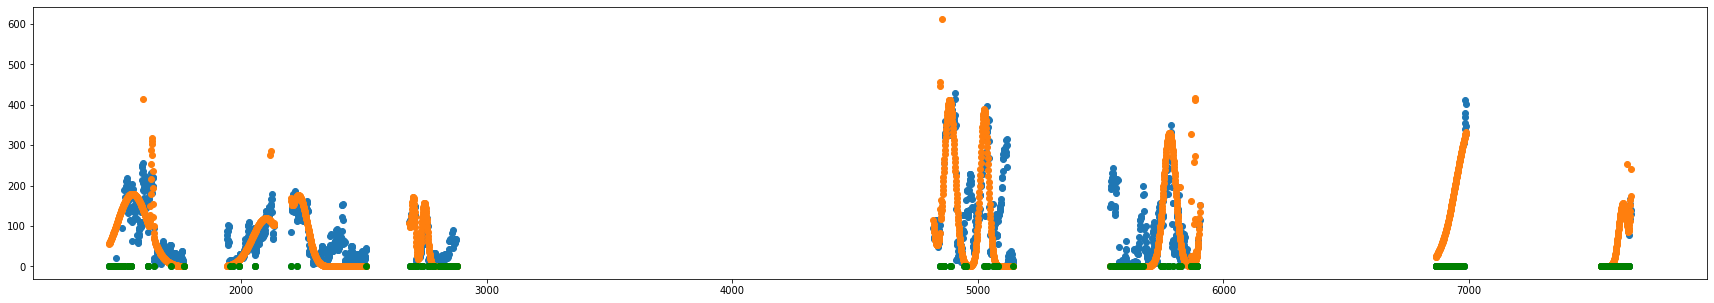

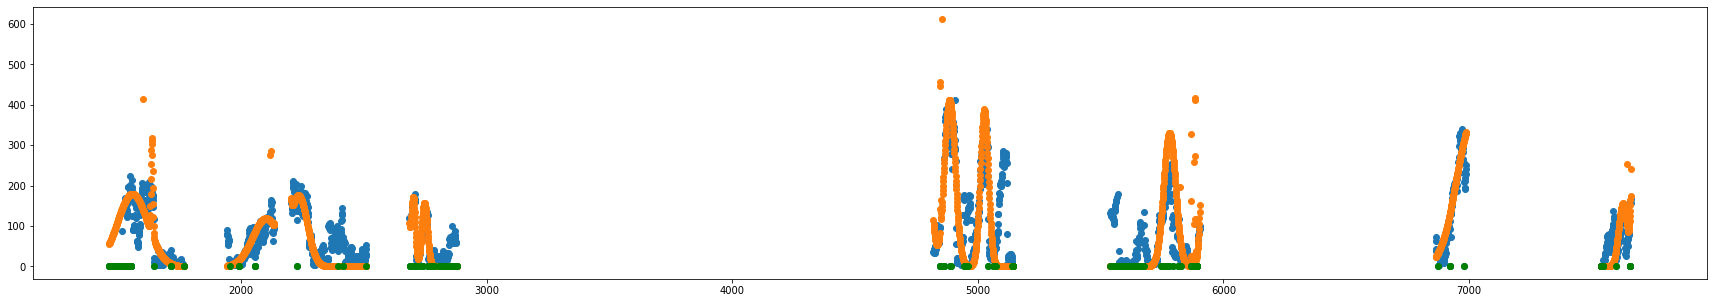

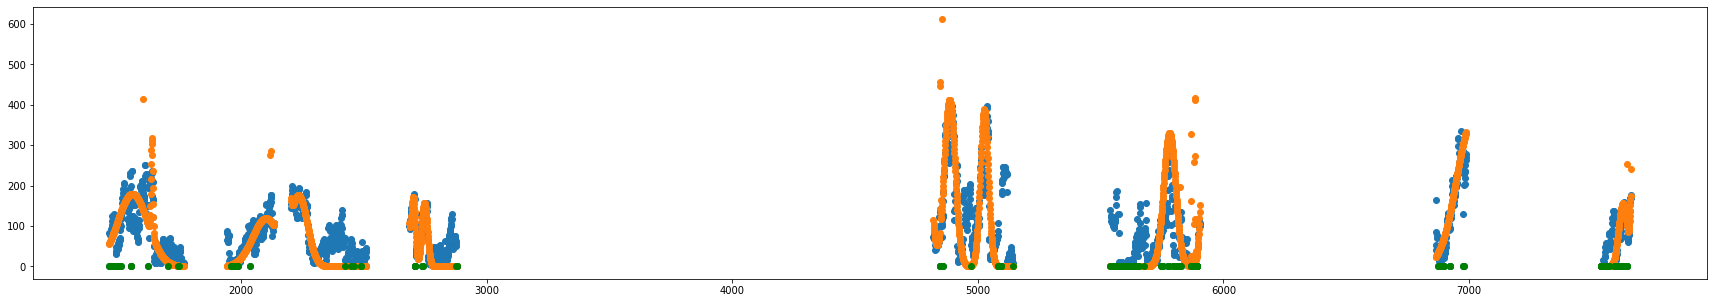

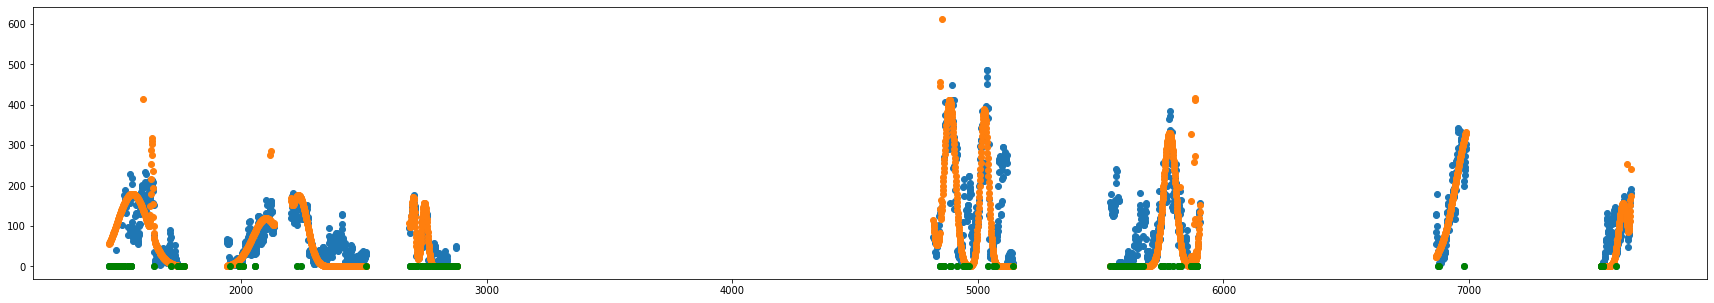

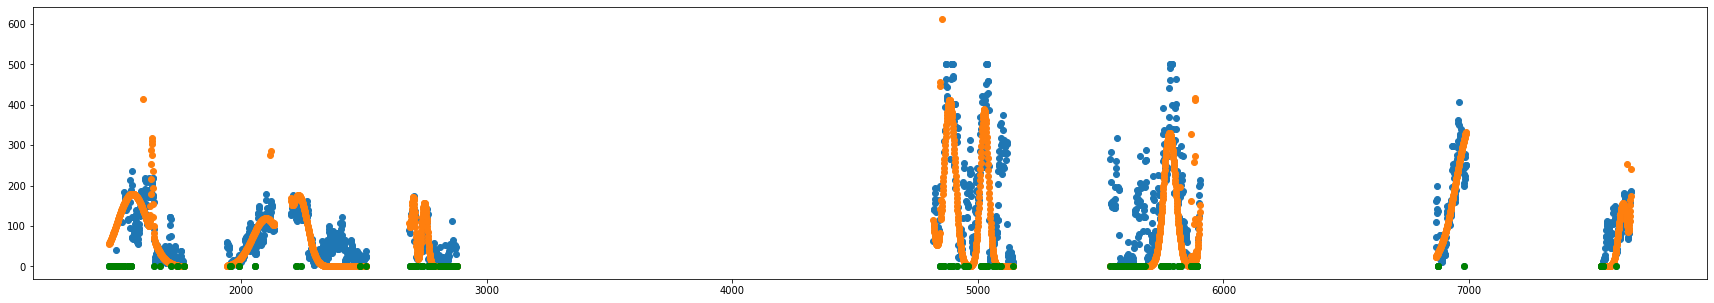

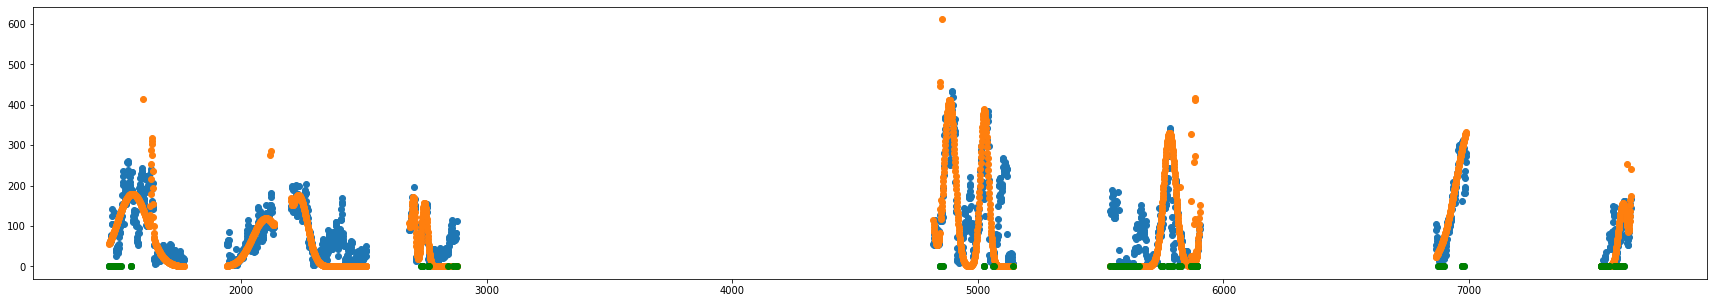

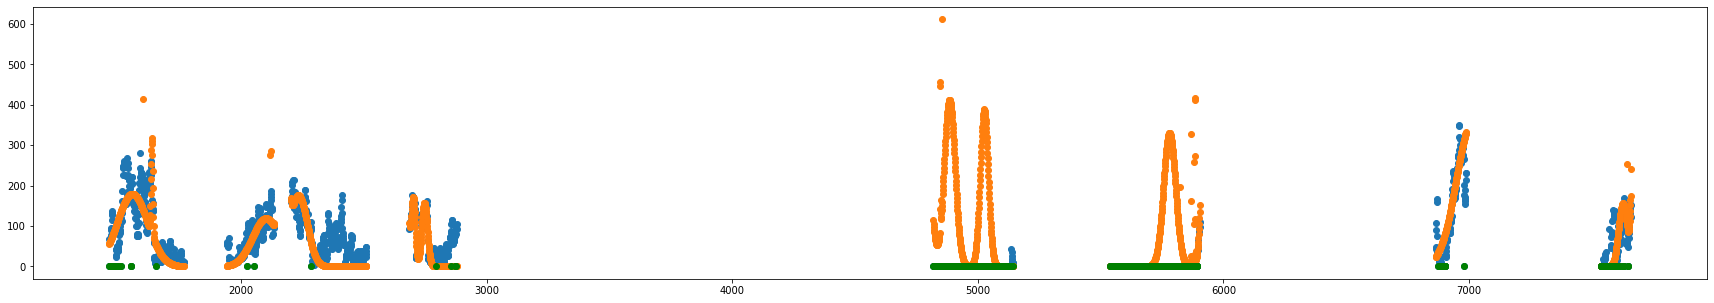

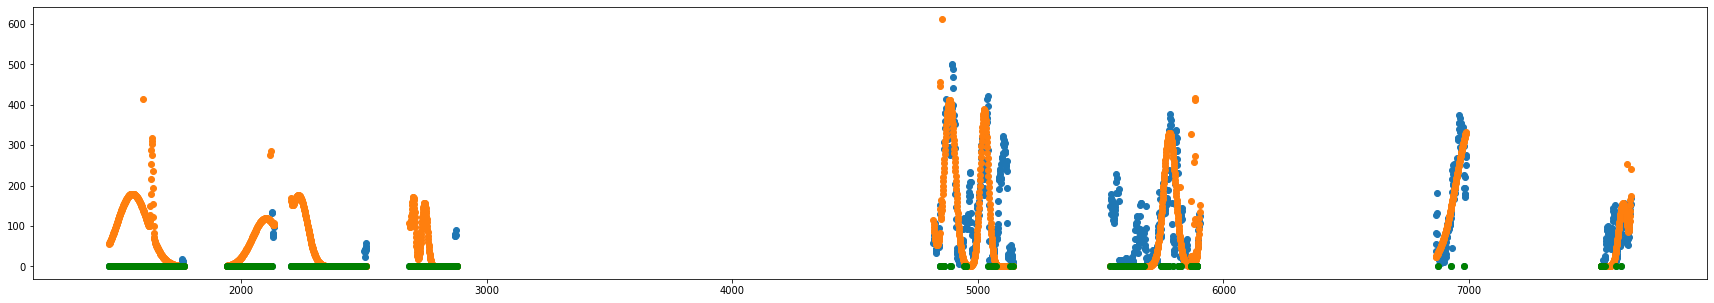

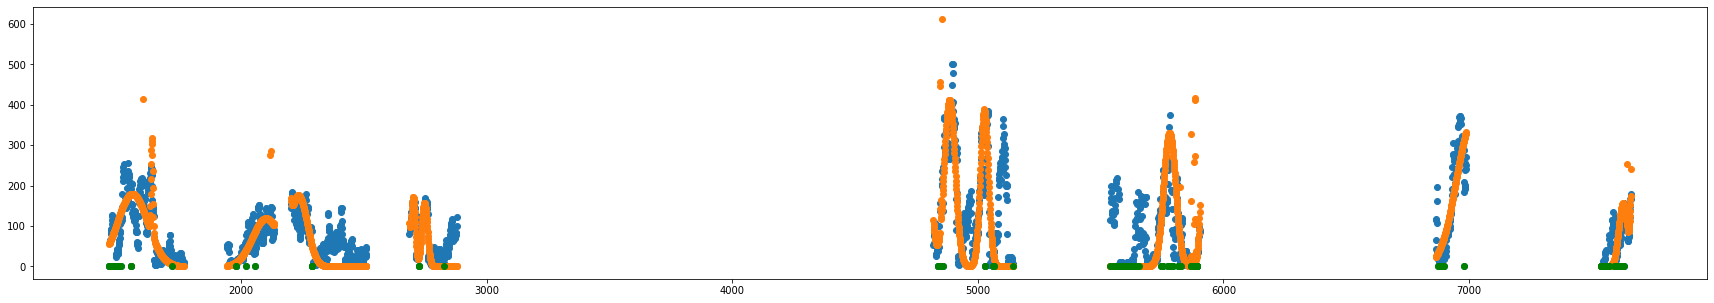

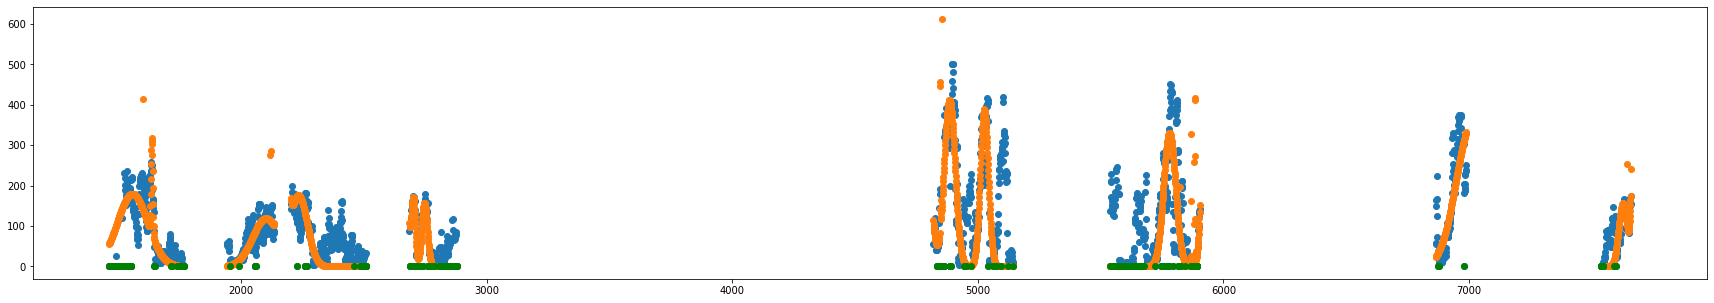

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 65.61825336737886
1th additional RBFlayer 999th epoch MSE Loss: 41.427021884878805
1th additional RBFlayer 1999th epoch MSE Loss: 41.1801783131361
1th additional RBFlayer 2999th epoch MSE Loss: 40.917671702115975
1th additional RBFlayer best loss : 40.917671702115975


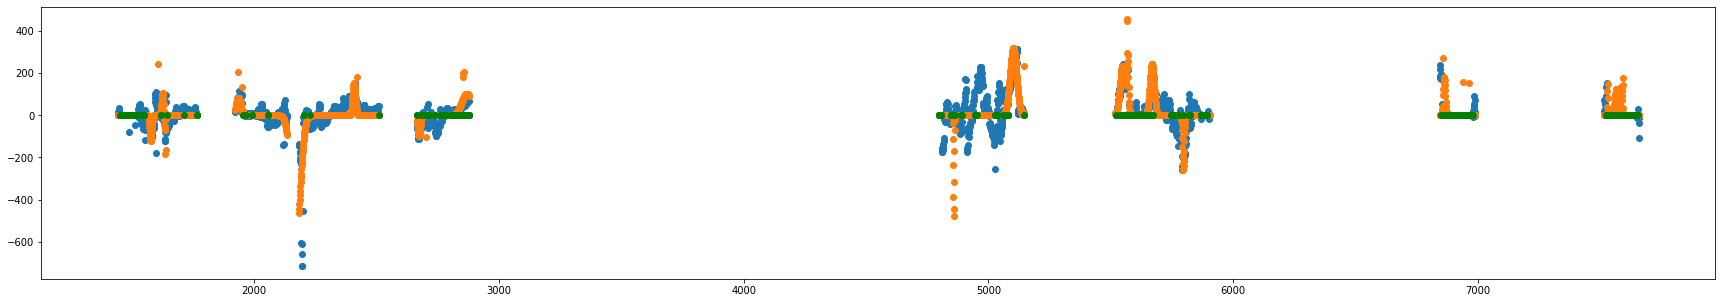

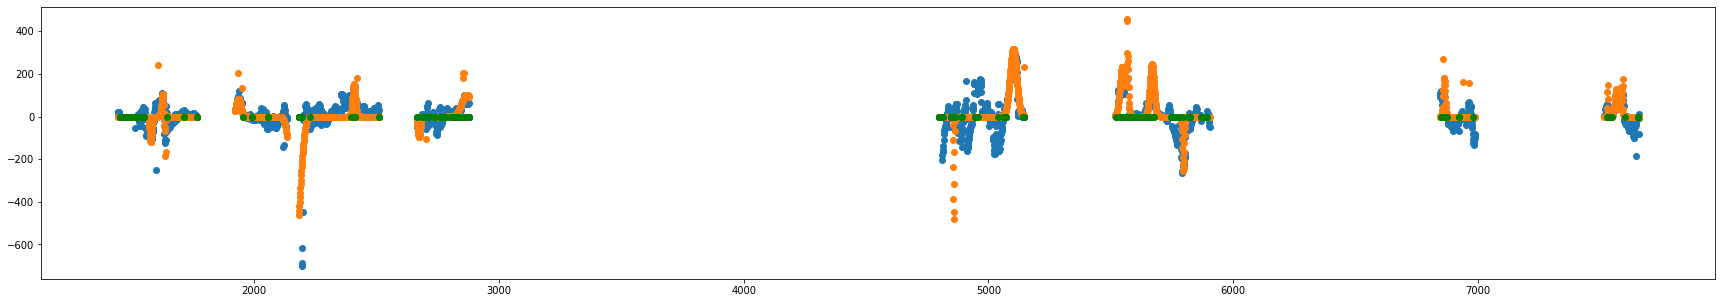

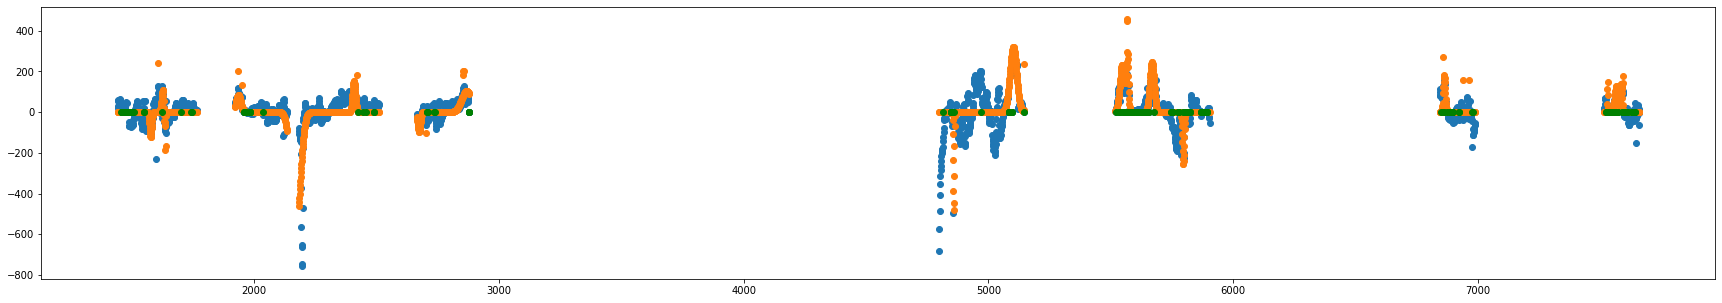

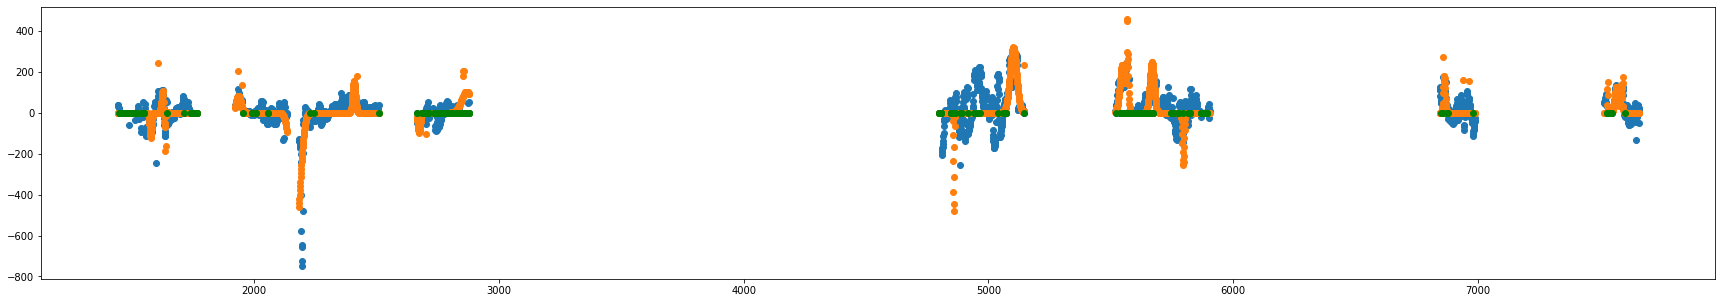

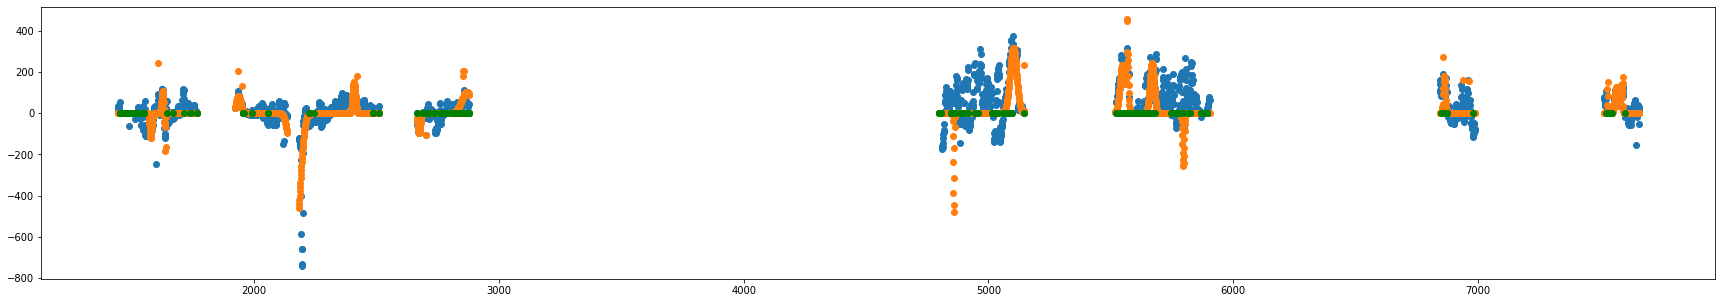

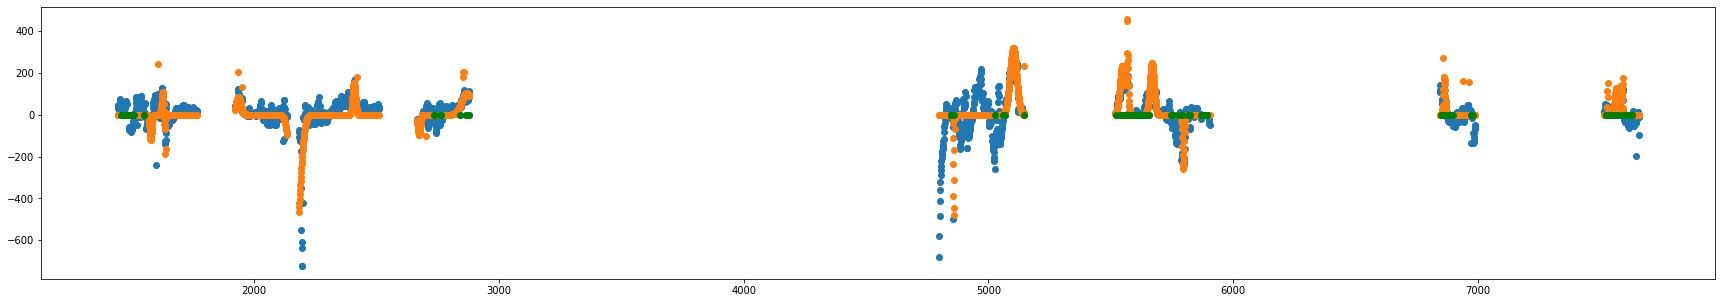

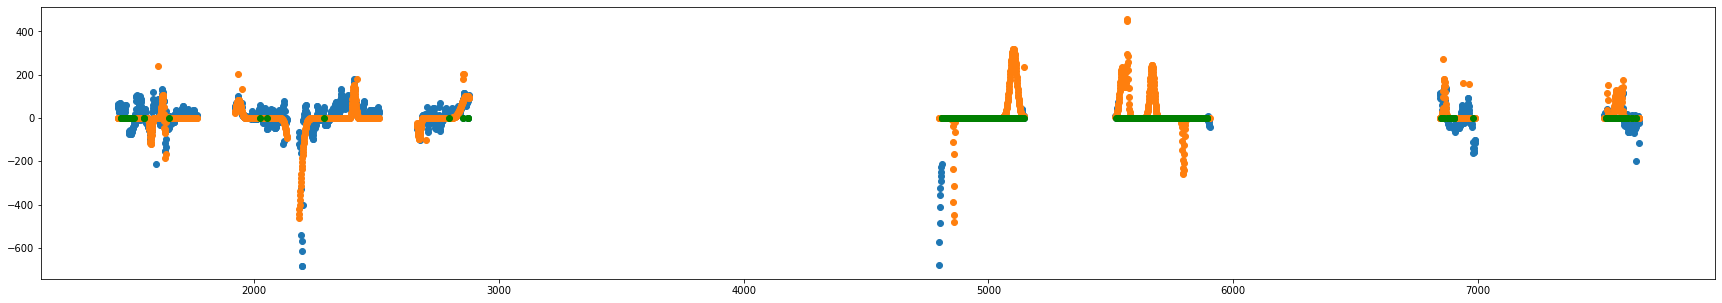

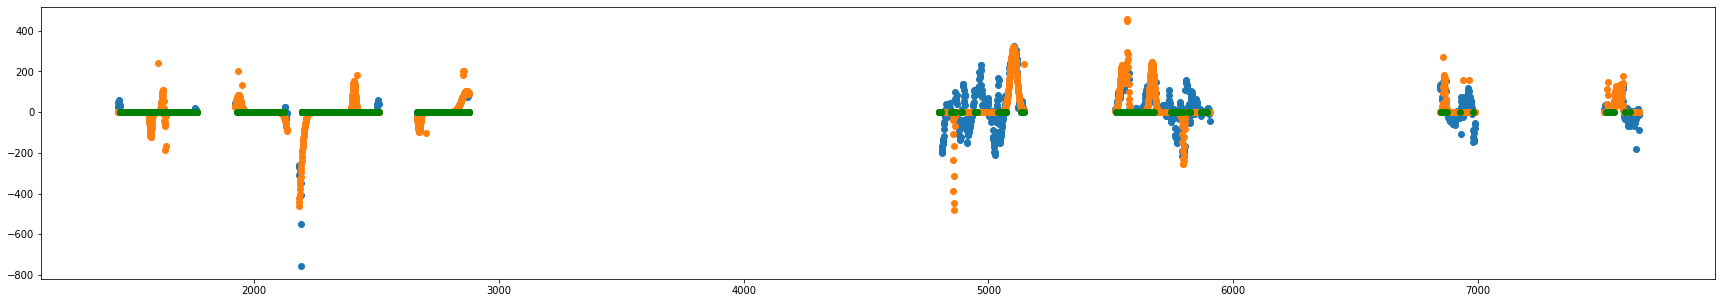

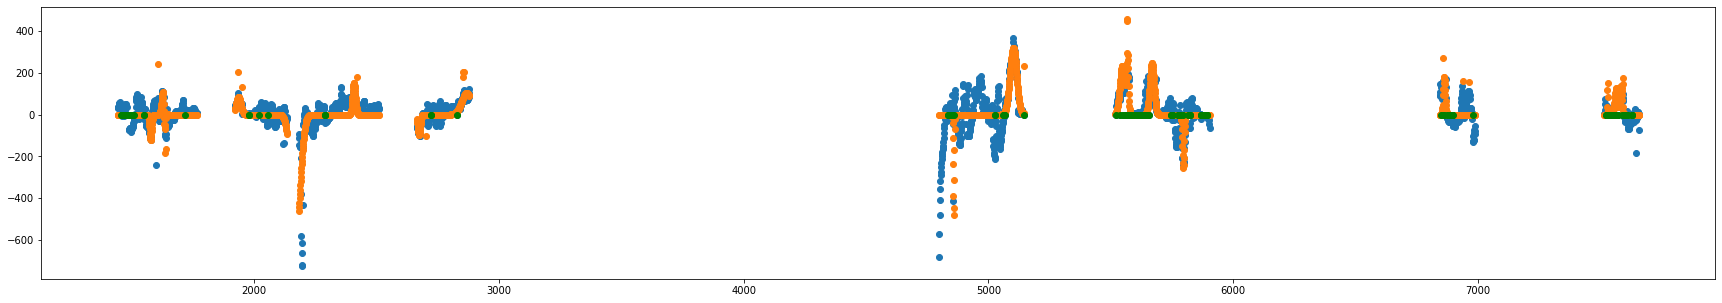

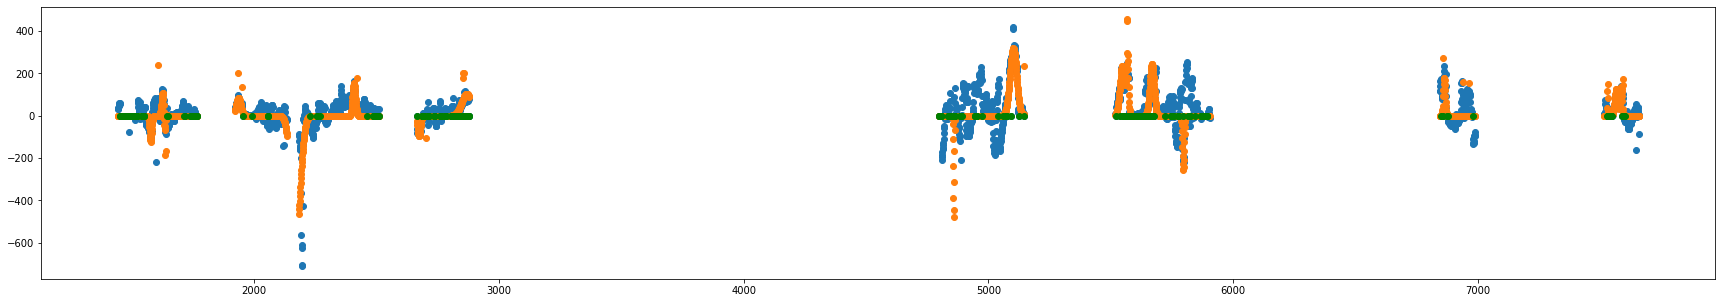

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 56.140745476304204
2th additional RBFlayer 999th epoch MSE Loss: 37.08633492825161
2th additional RBFlayer 1999th epoch MSE Loss: 36.65563752076764
2th additional RBFlayer 2999th epoch MSE Loss: 36.752293278484515
2th additional RBFlayer best loss : 36.612891634045454


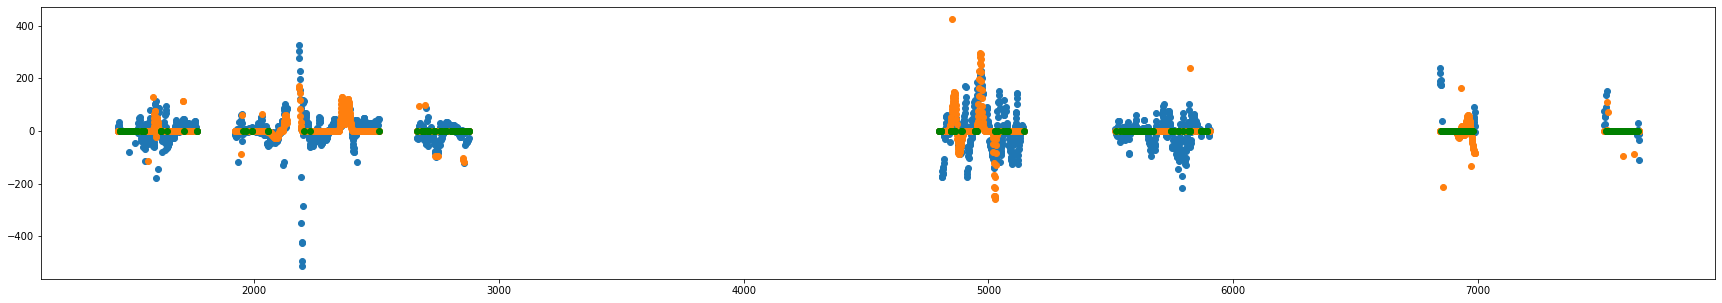

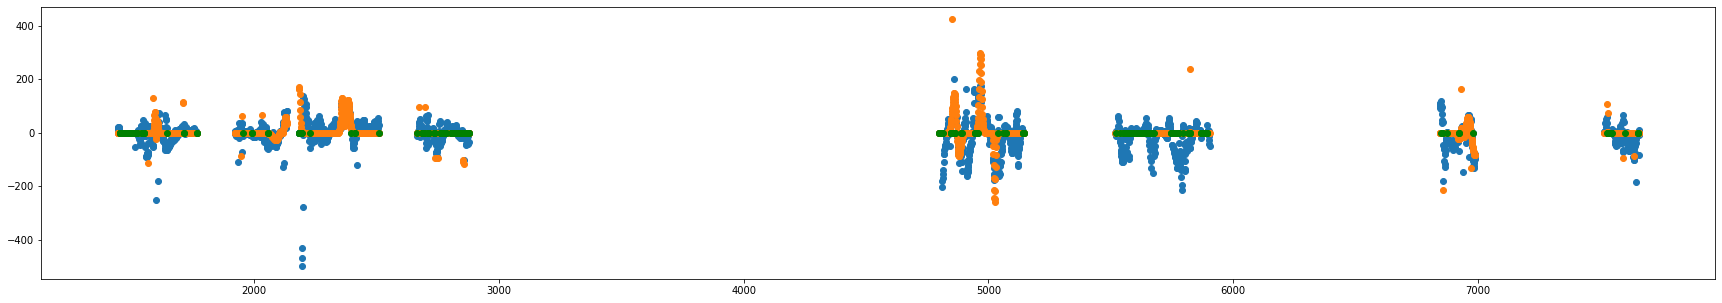

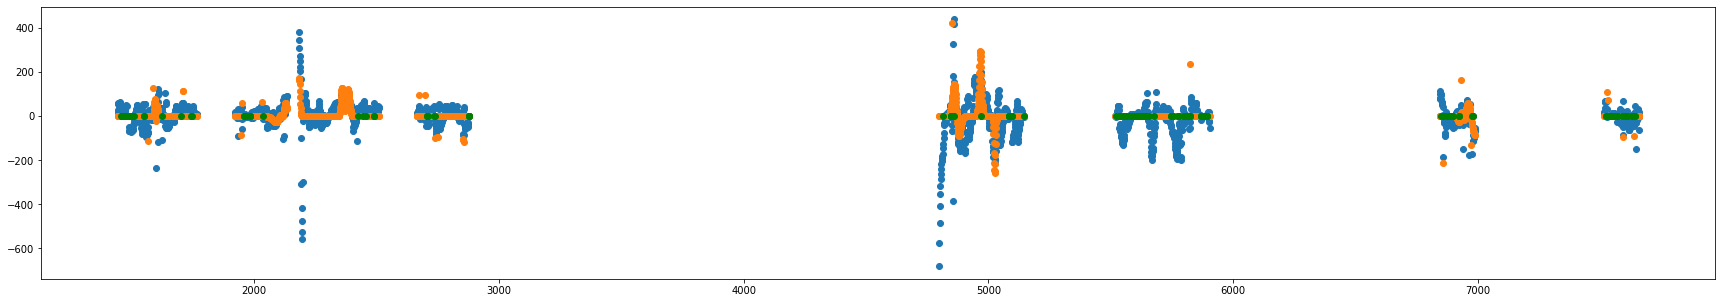

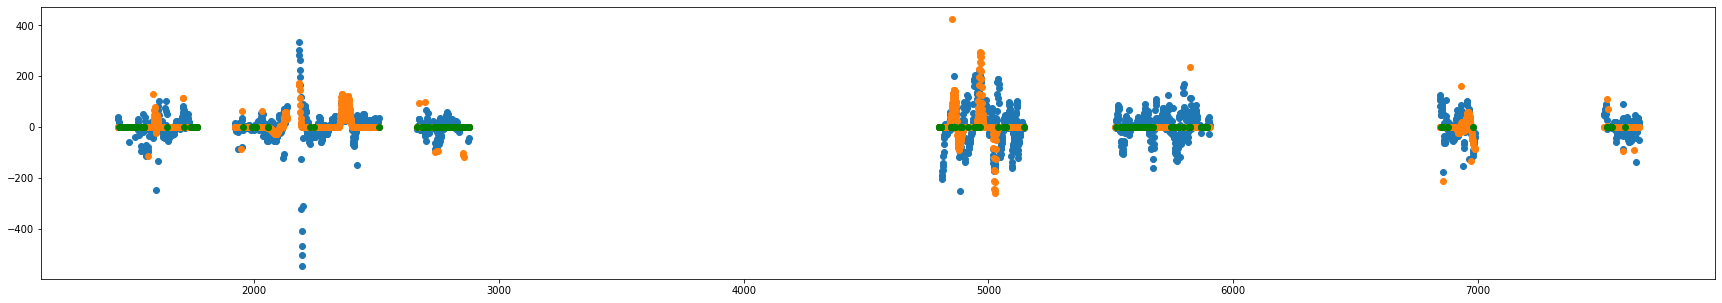

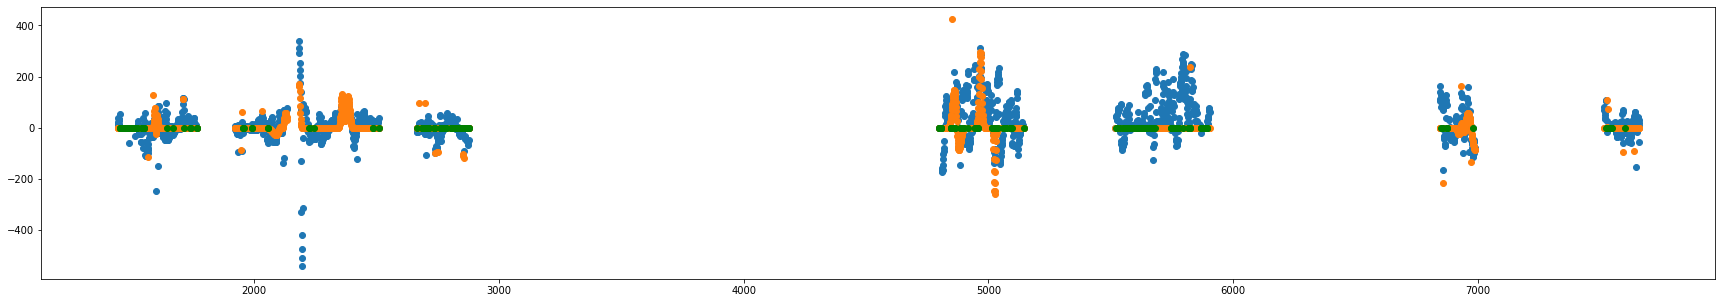

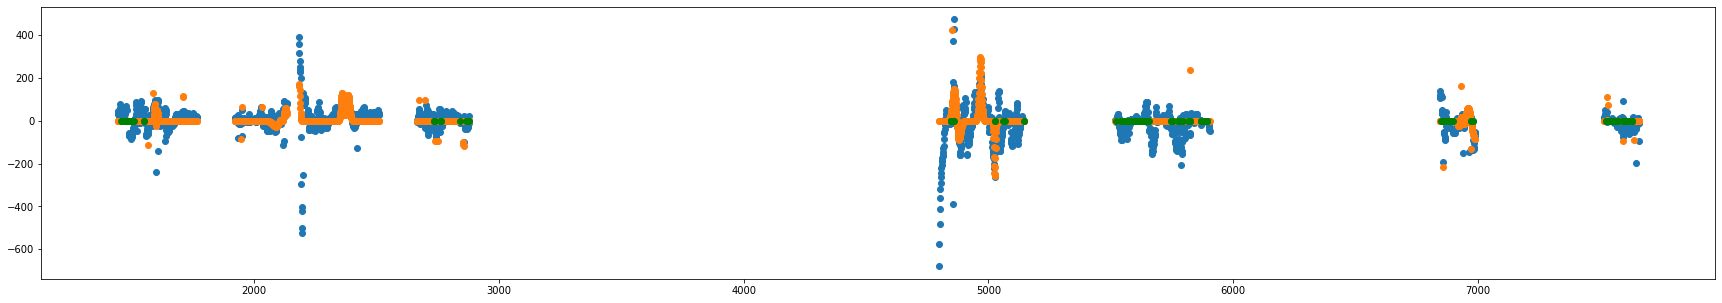

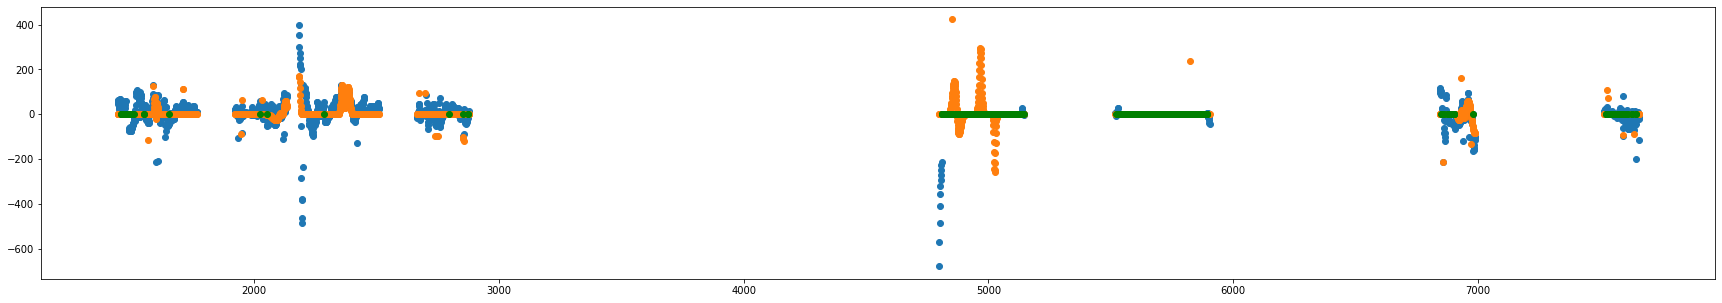

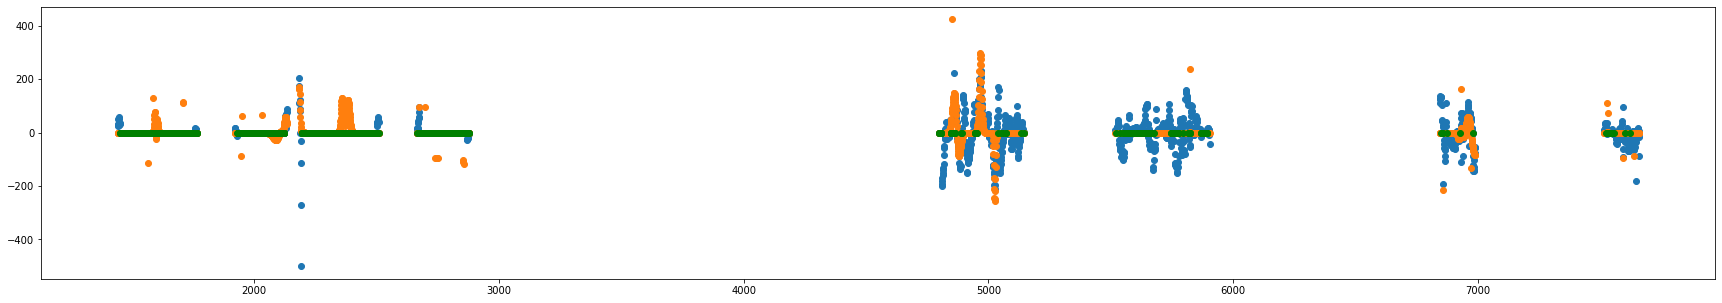

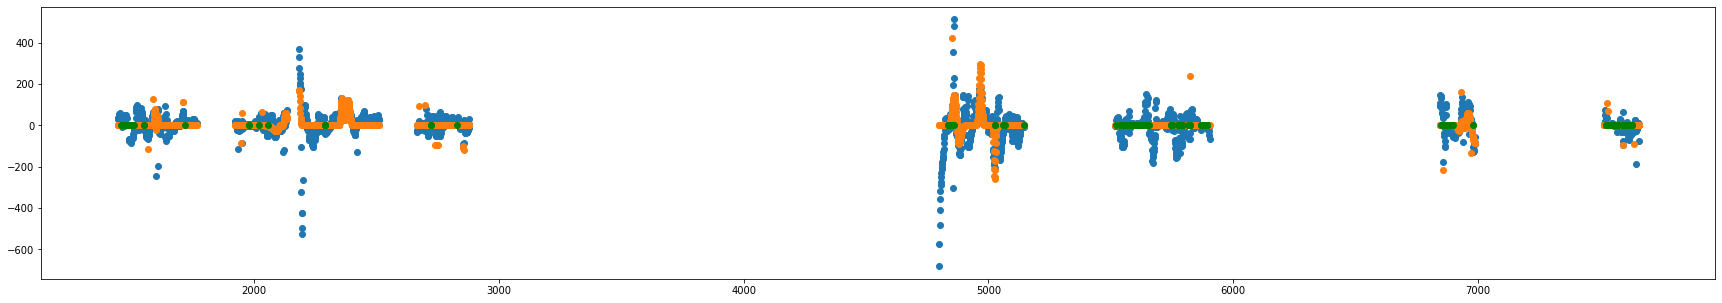

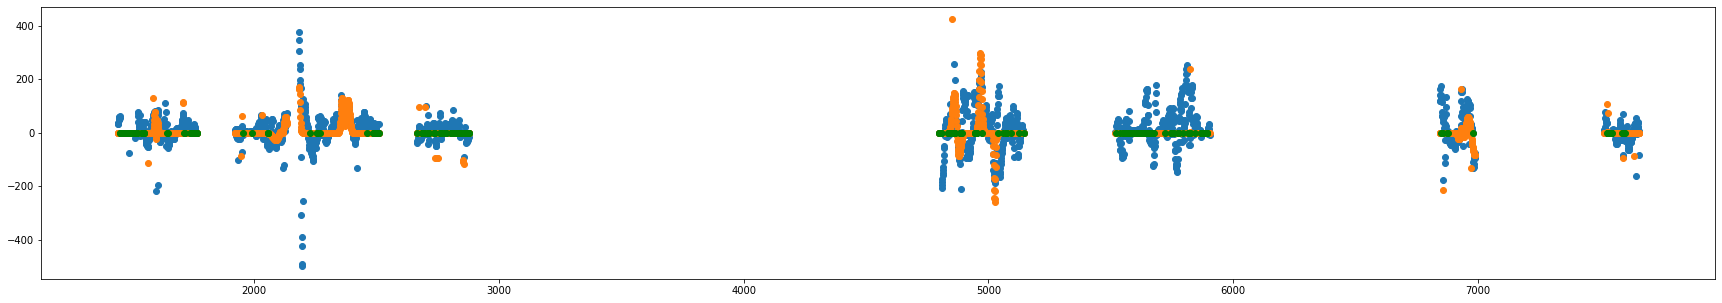

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 50.933343896039176
3th additional RBFlayer 999th epoch MSE Loss: 38.95843876001812
3th additional RBFlayer 1999th epoch MSE Loss: 35.705669348000846
3th additional RBFlayer 2999th epoch MSE Loss: 34.90217545682331
3th additional RBFlayer best loss : 34.56491748396936


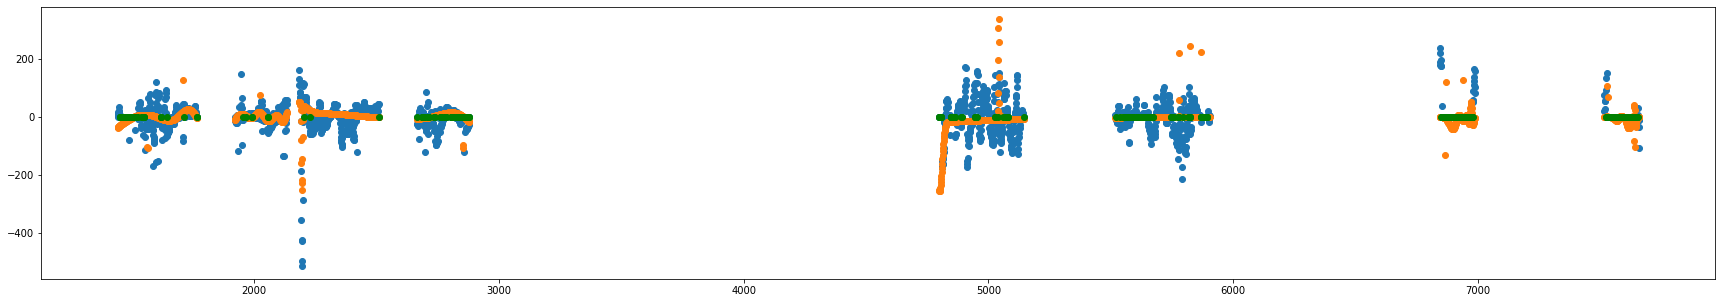

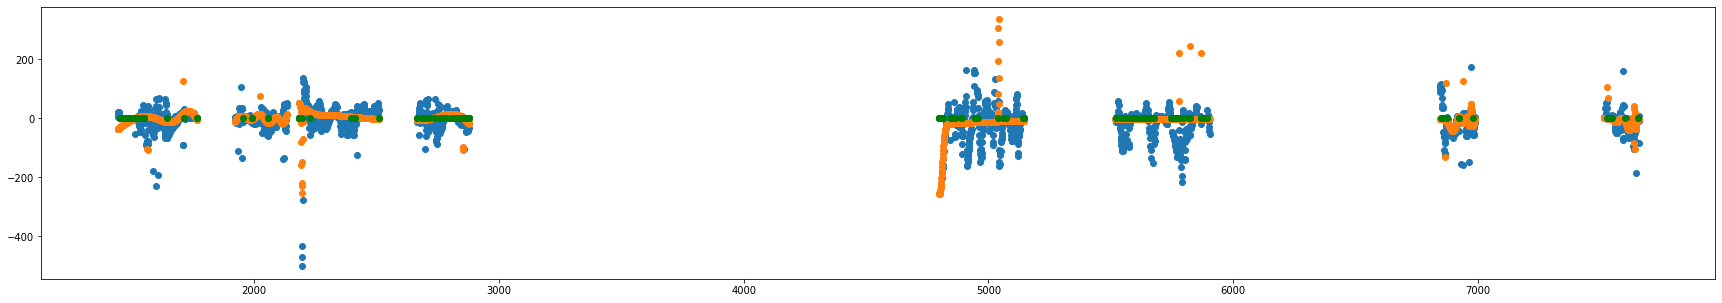

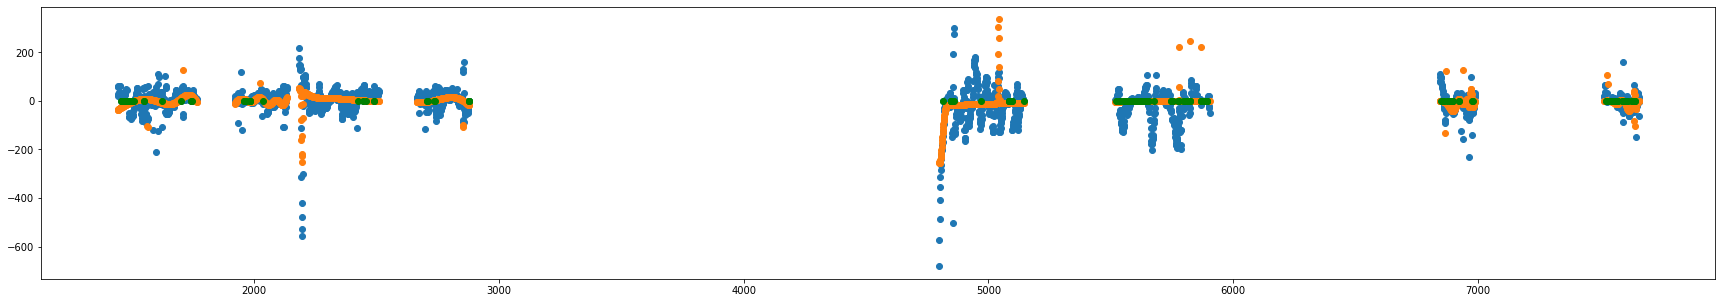

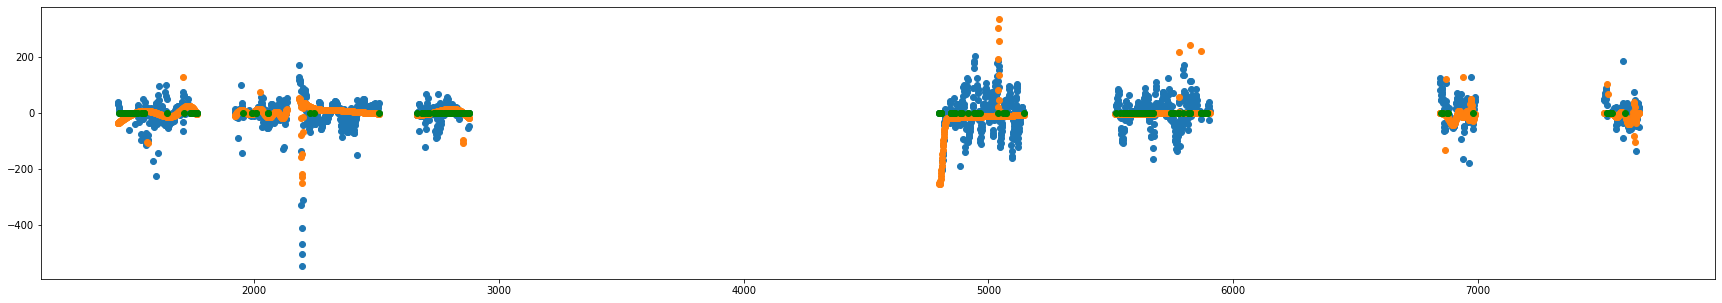

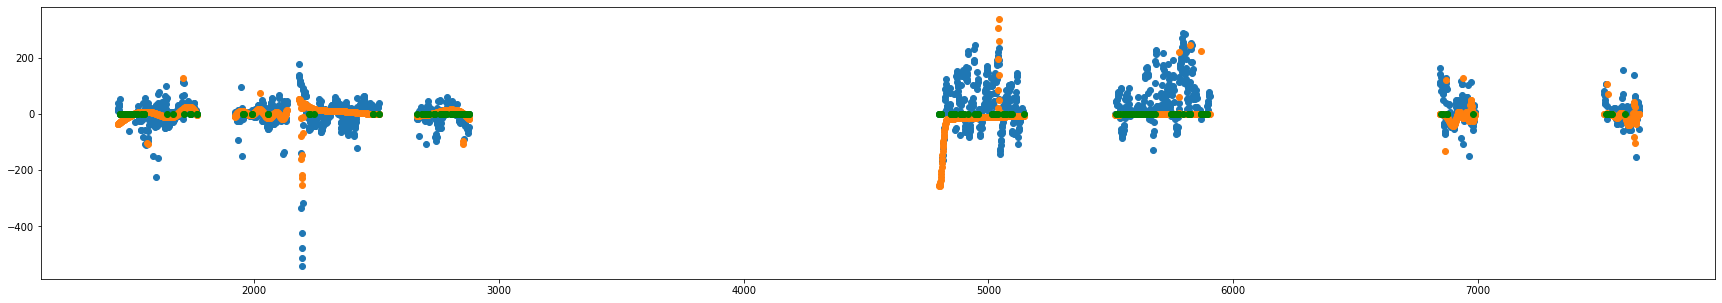

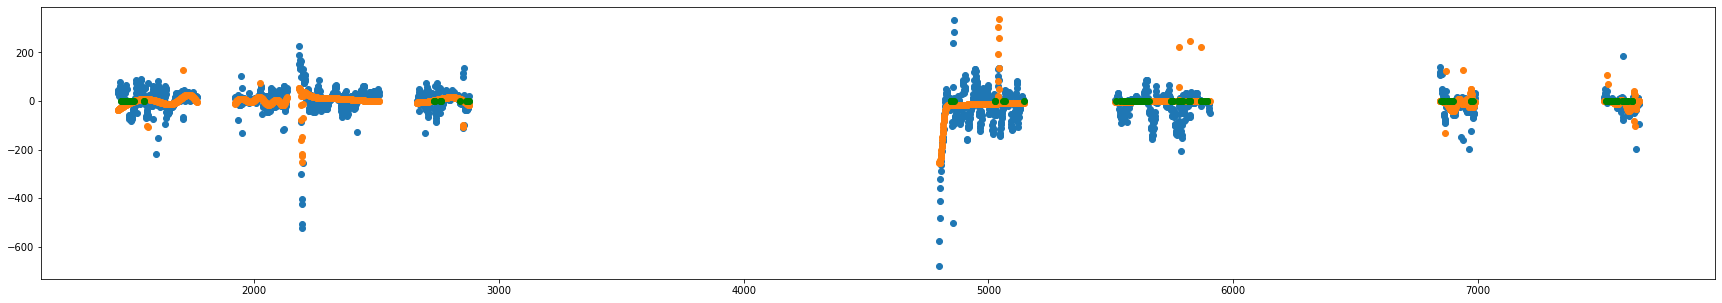

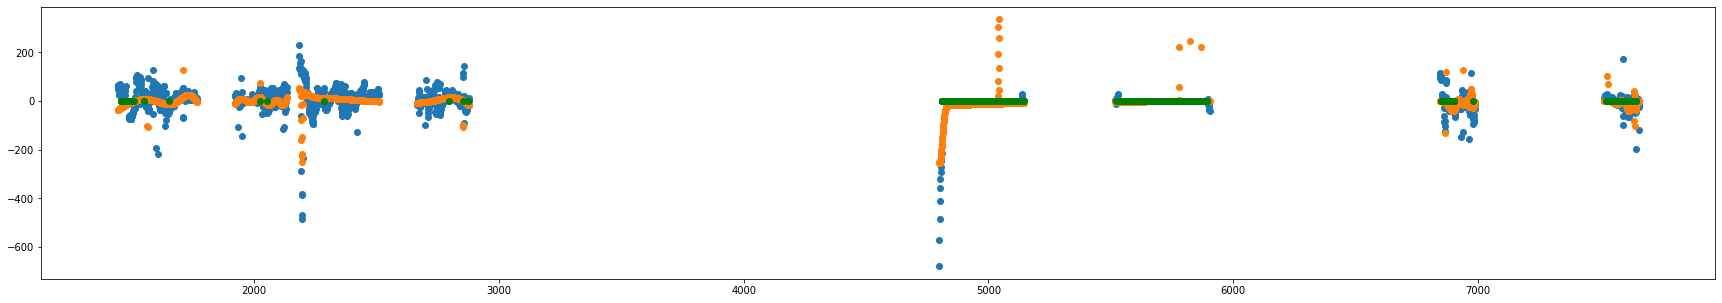

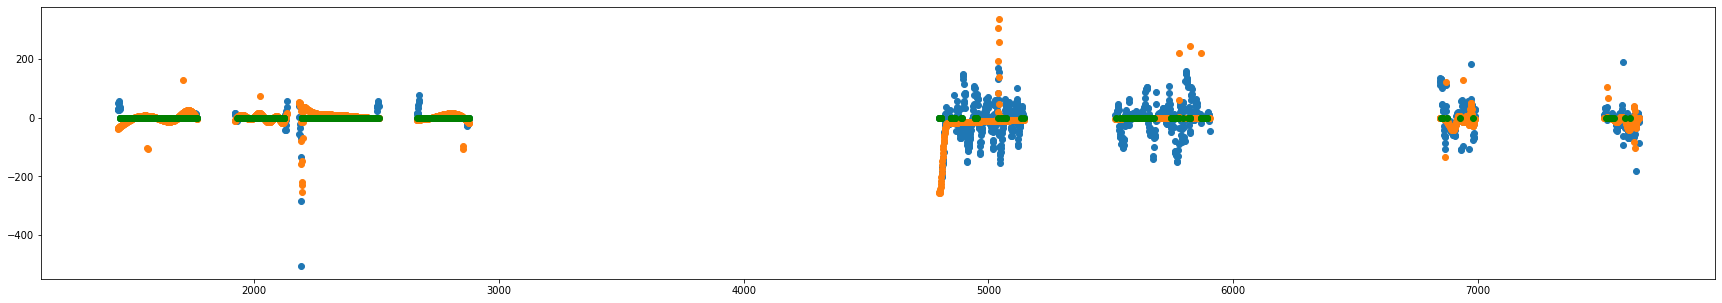

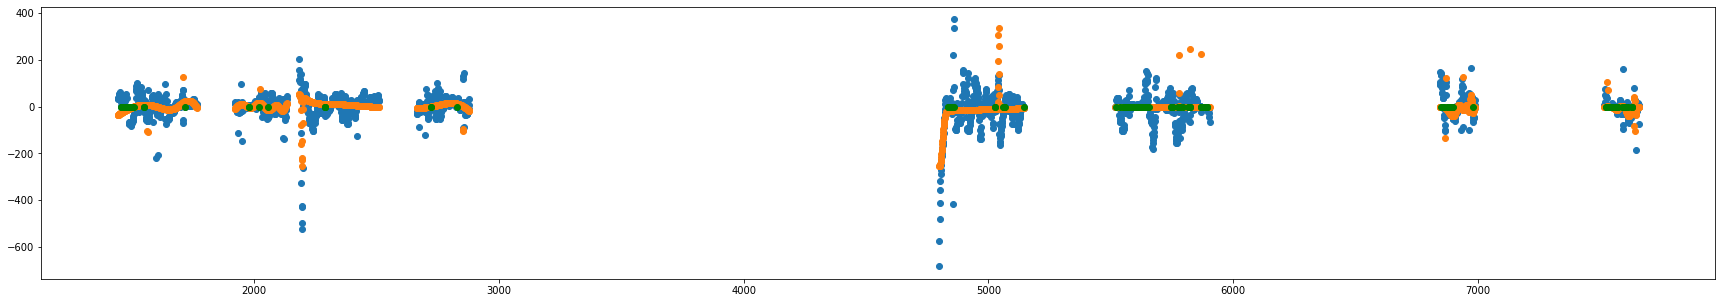

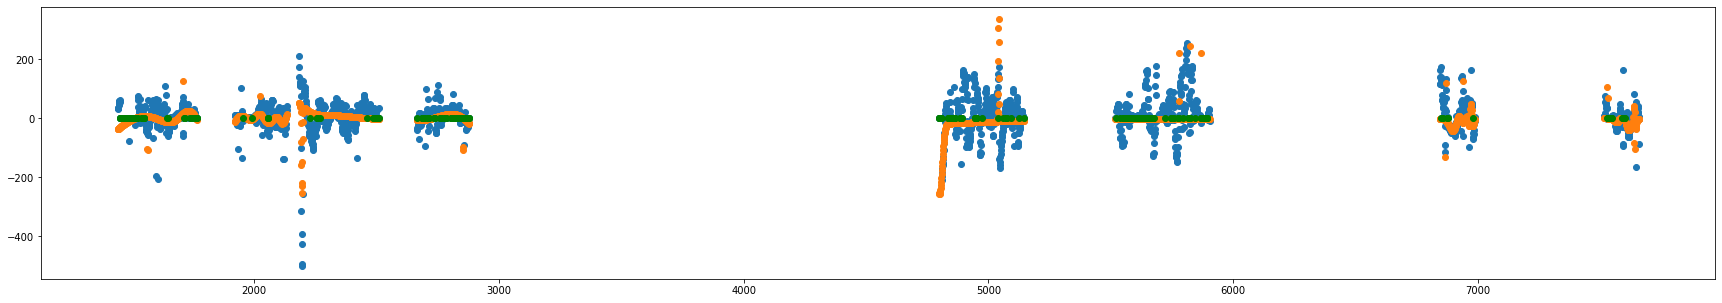

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 46.2596868934115
4th additional RBFlayer 999th epoch MSE Loss: 33.82870037704942
4th additional RBFlayer 1999th epoch MSE Loss: 33.76036856089123
4th additional RBFlayer 2999th epoch MSE Loss: 33.771749985796816
4th additional RBFlayer best loss : 33.22538899123239


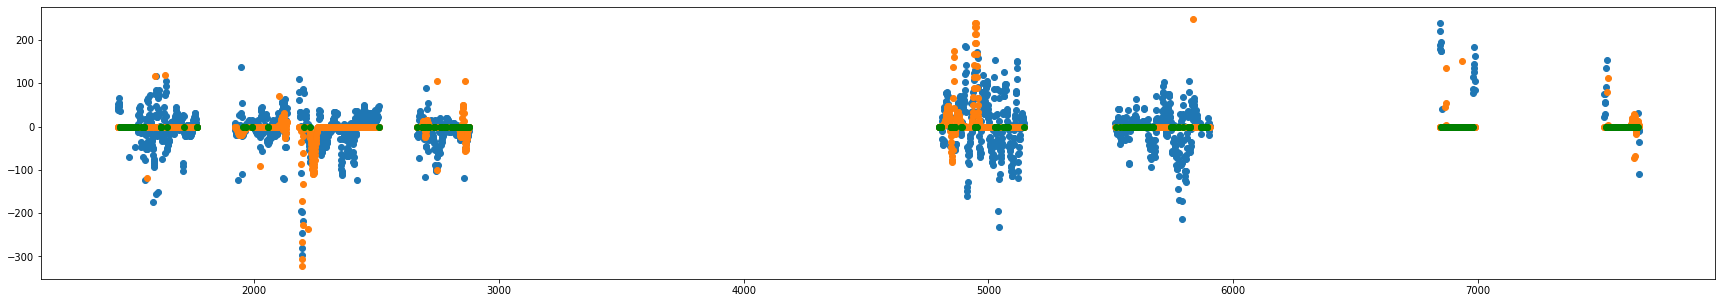

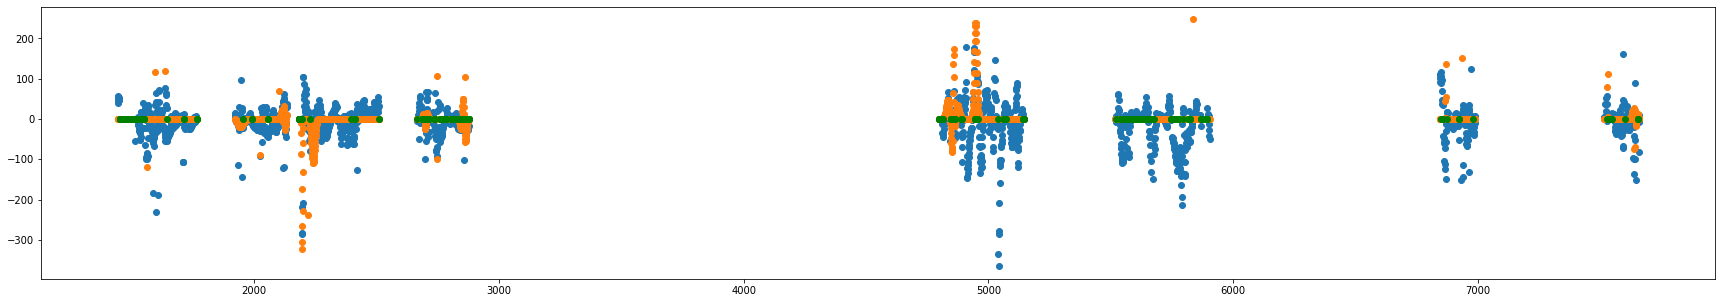

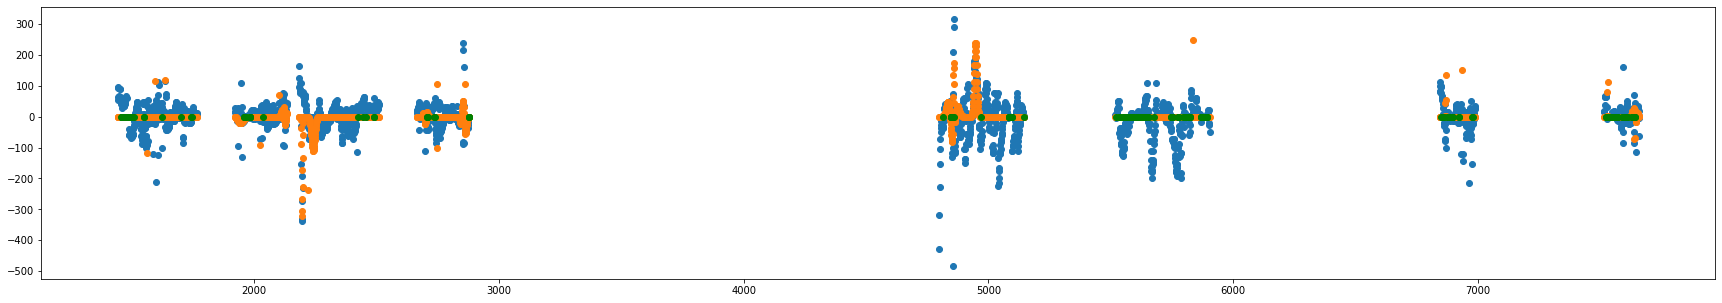

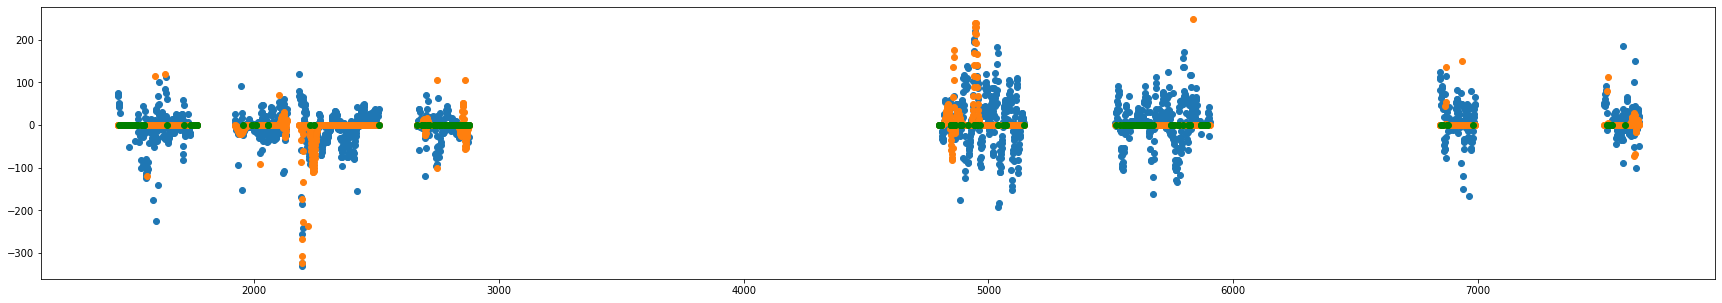

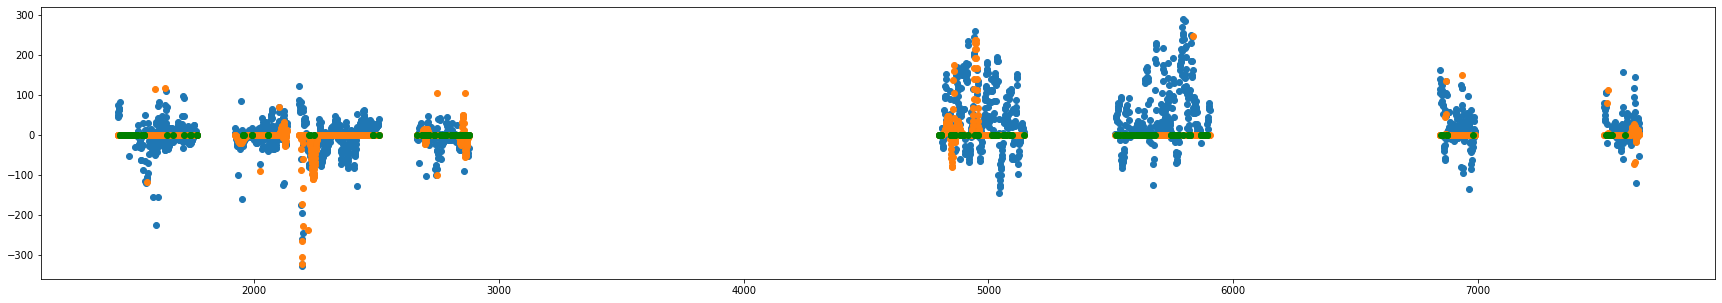

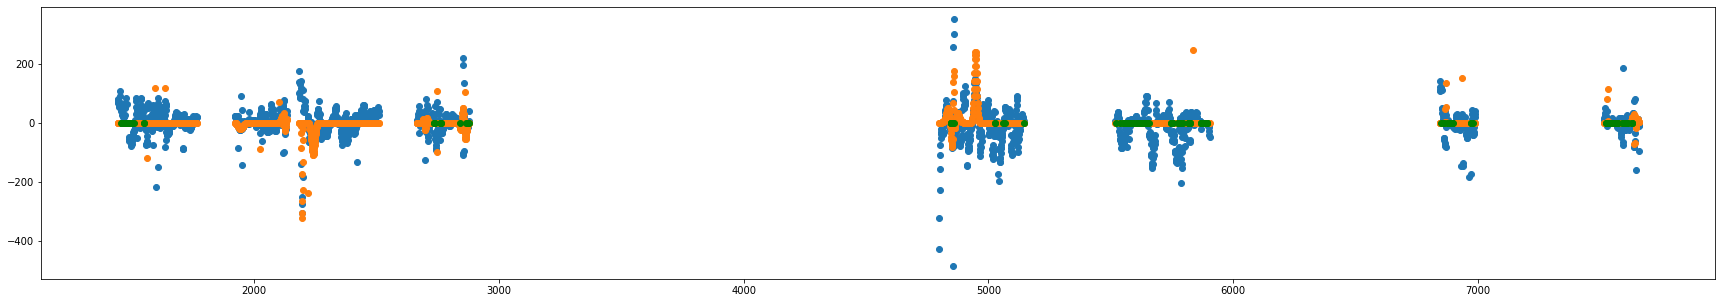

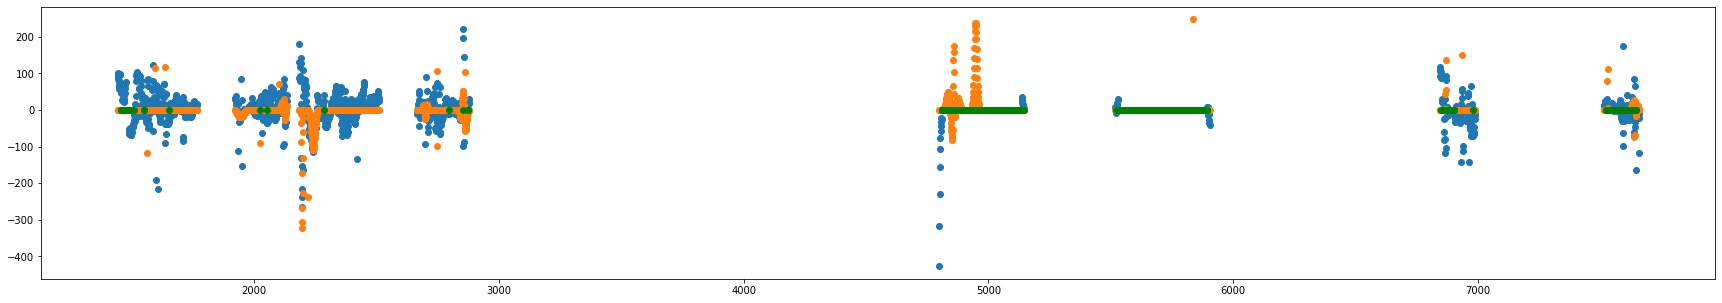

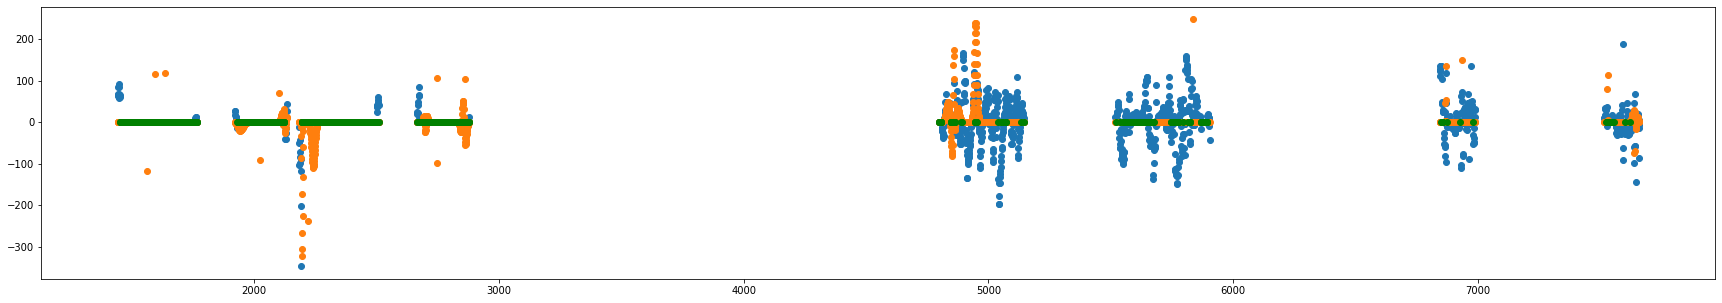

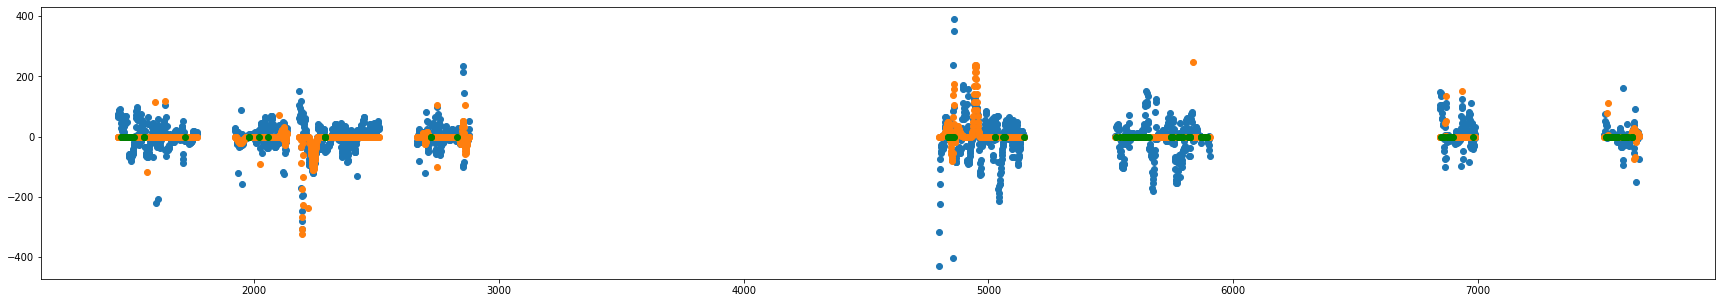

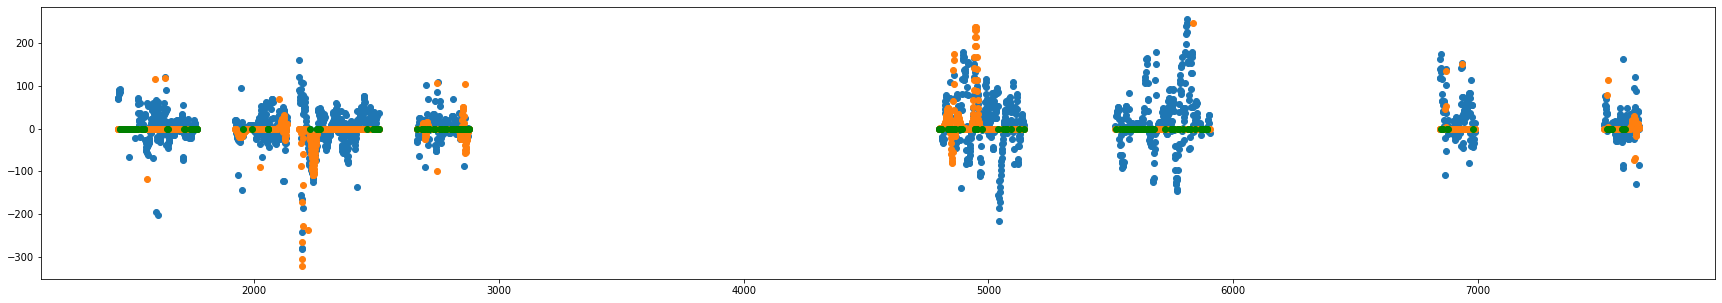

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 42.43170478634732
5th additional RBFlayer 999th epoch MSE Loss: 32.62131966176389
5th additional RBFlayer 1999th epoch MSE Loss: 32.366197964815
5th additional RBFlayer 2999th epoch MSE Loss: 32.28895756215612
5th additional RBFlayer best loss : 32.25781168270287


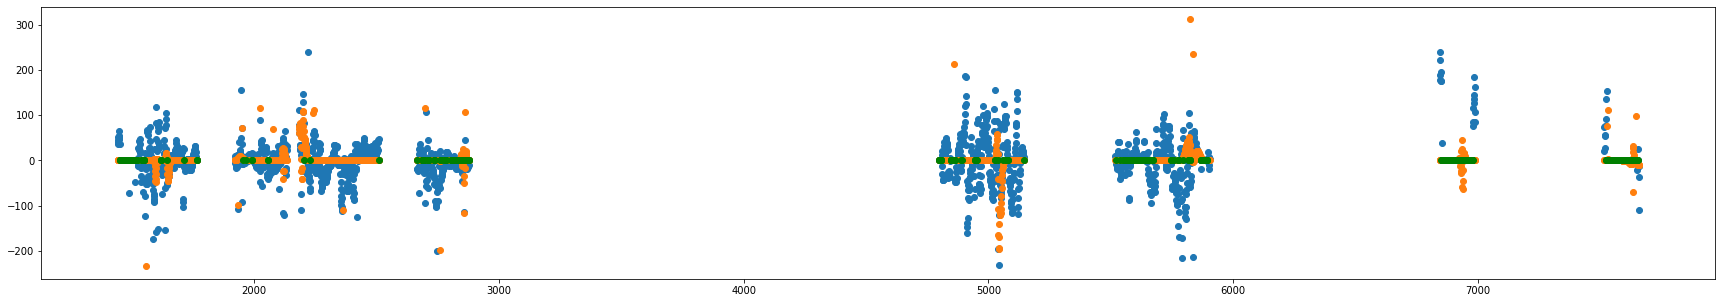

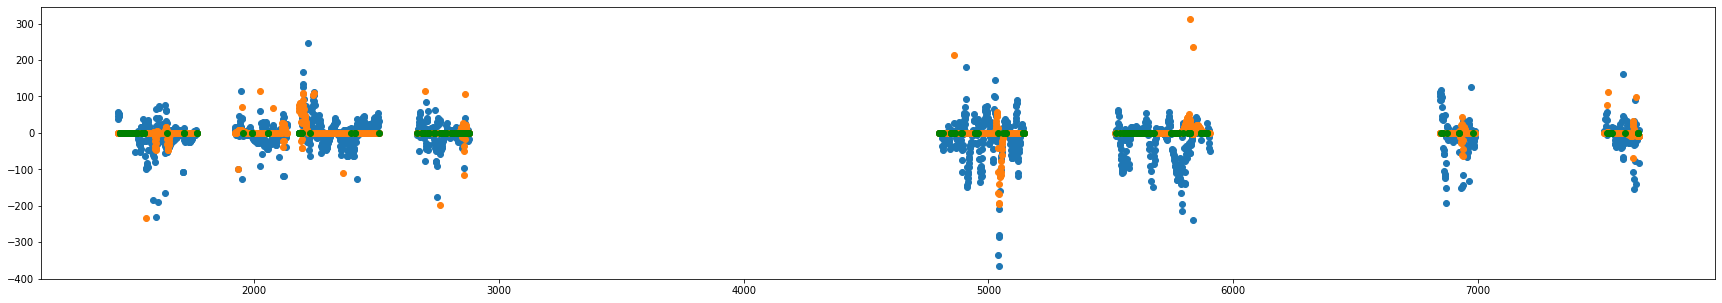

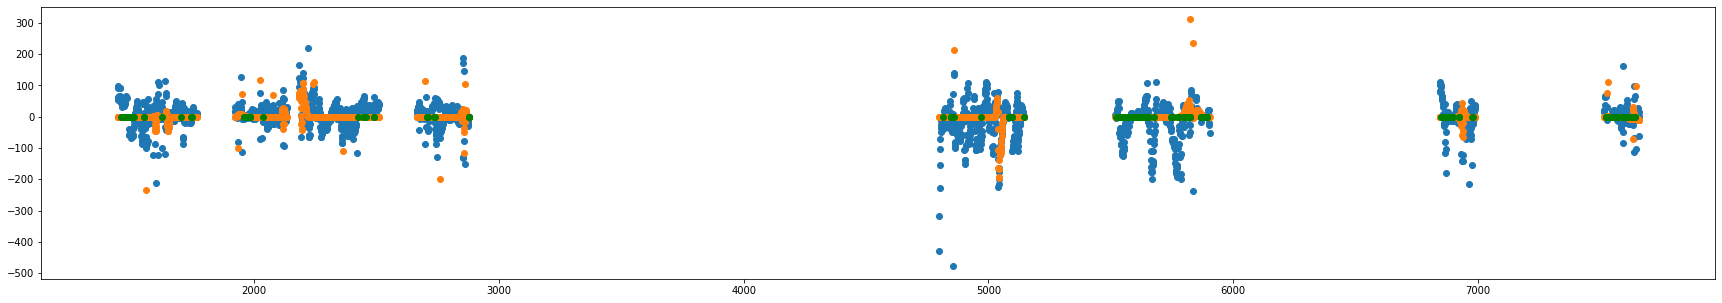

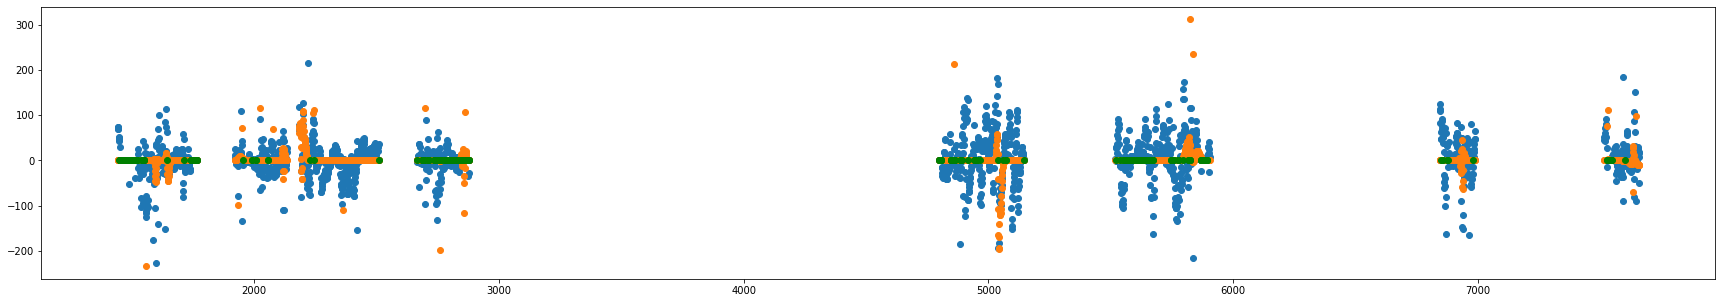

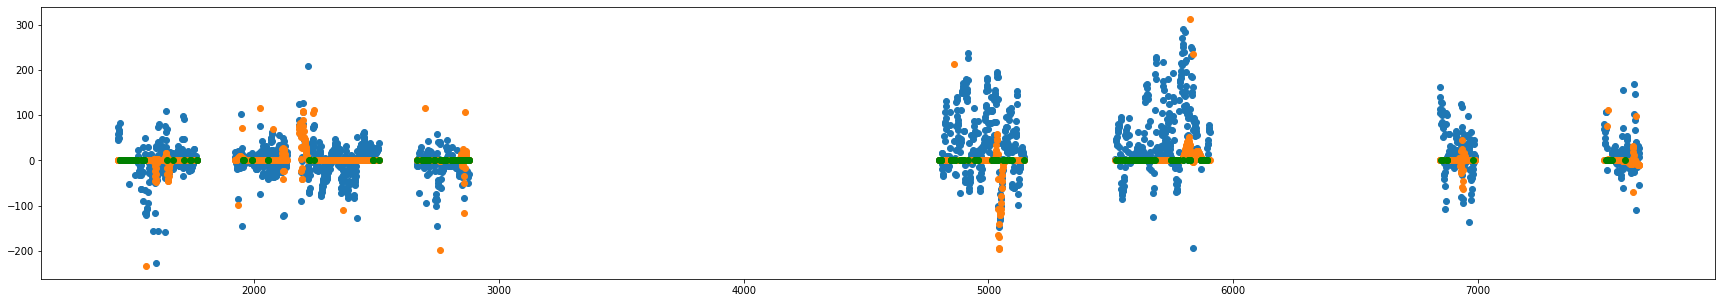

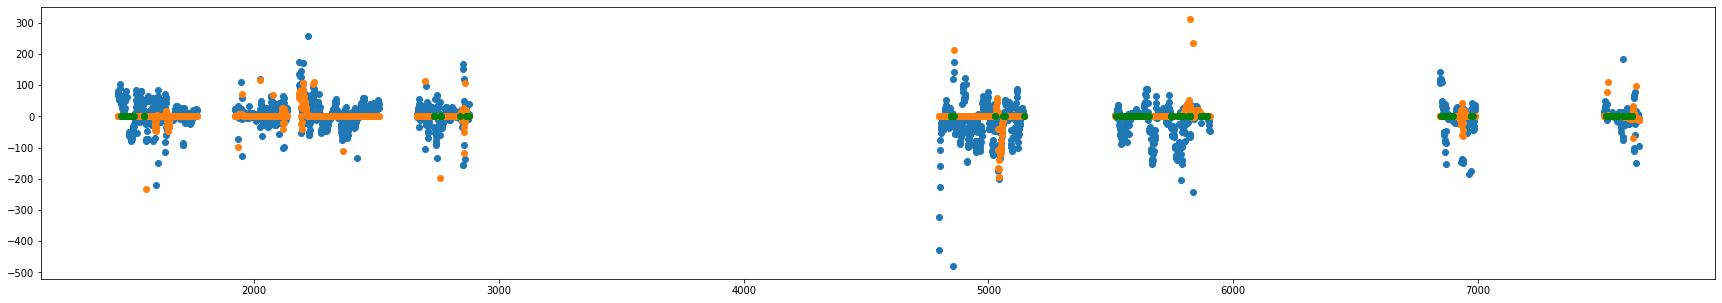

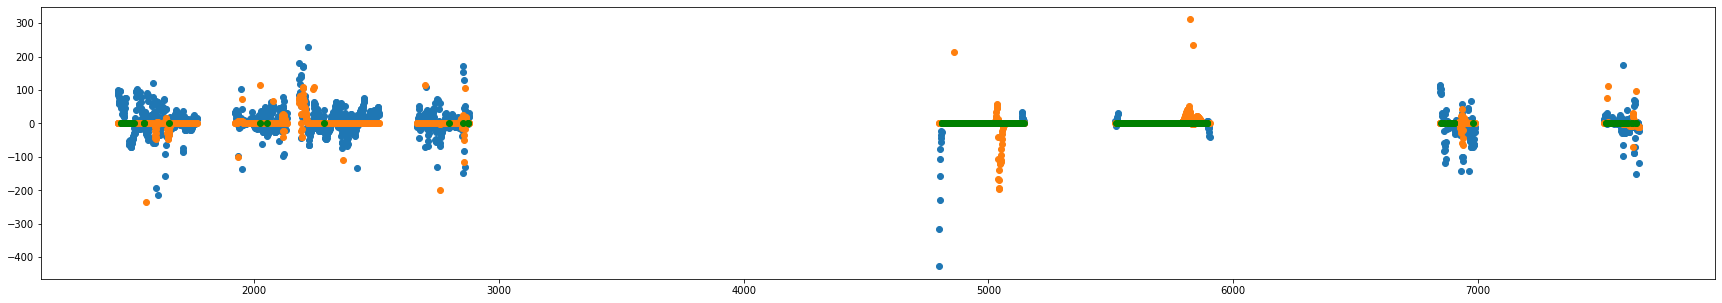

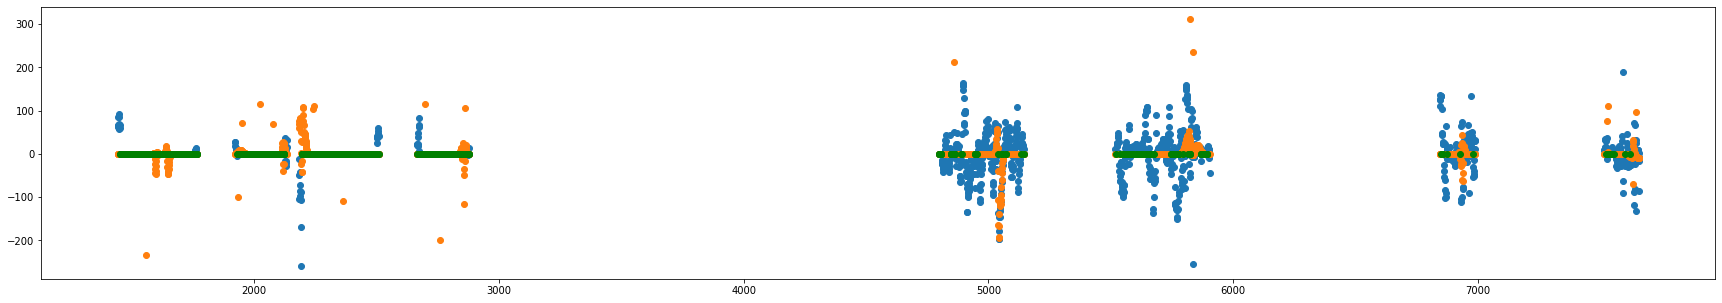

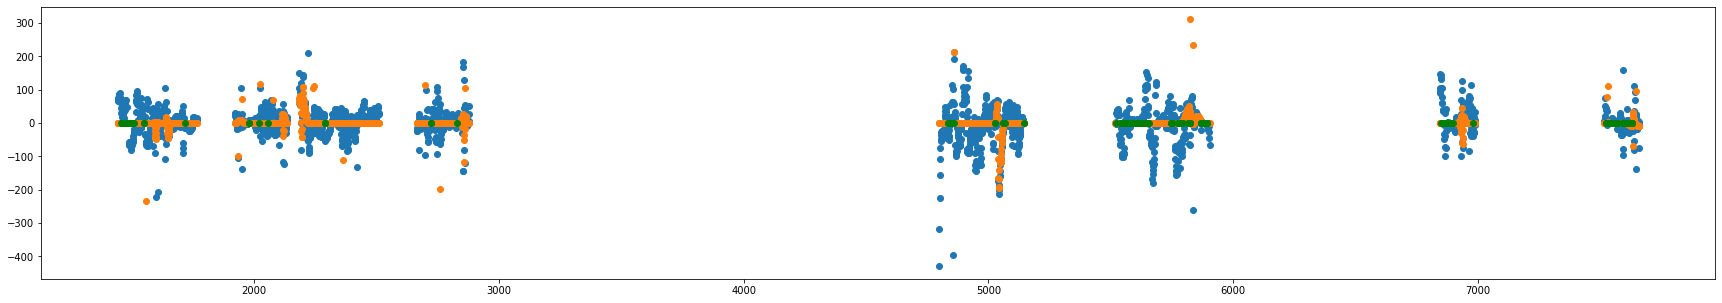

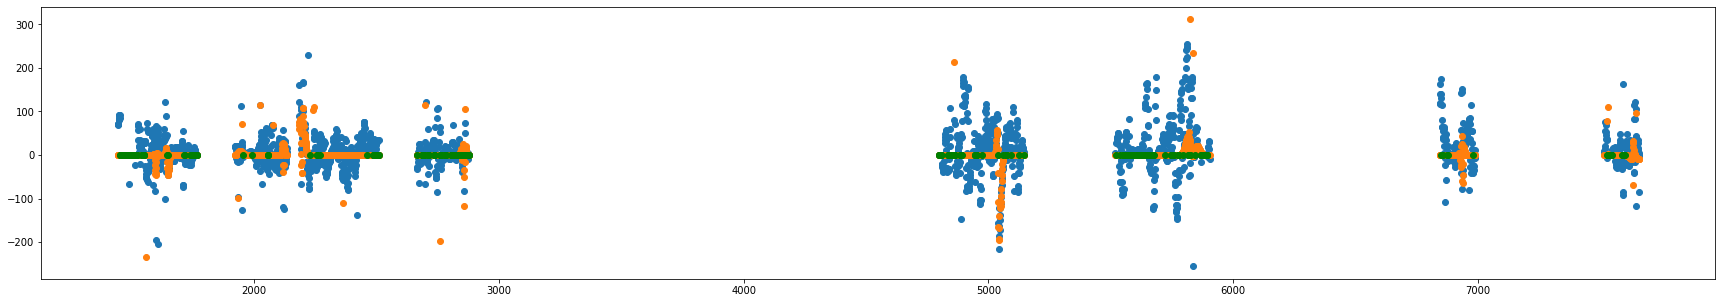

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 41.273098952555095
6th additional RBFlayer 999th epoch MSE Loss: 32.73658022562238
6th additional RBFlayer 1999th epoch MSE Loss: 32.40944146439951
6th additional RBFlayer 2999th epoch MSE Loss: 32.31998747823706
6th additional RBFlayer best loss : 32.31998747823706


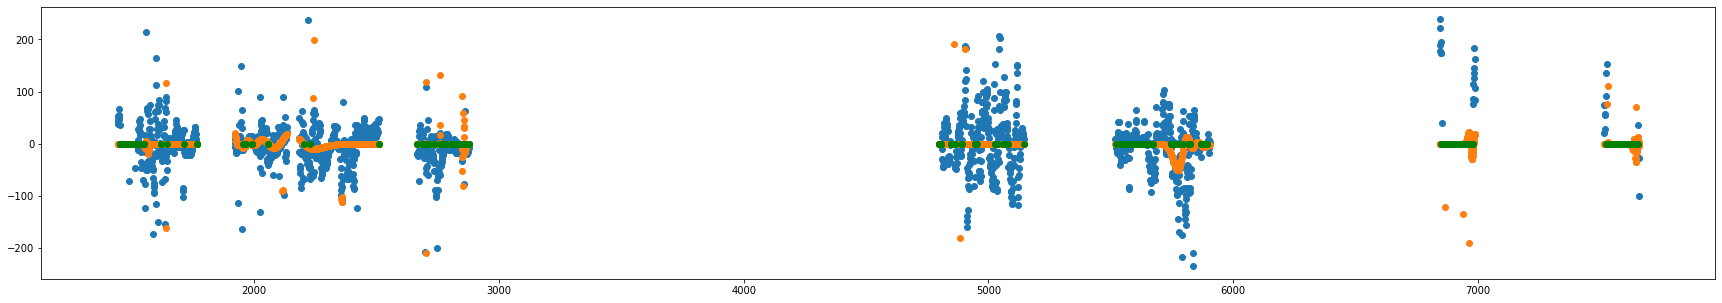

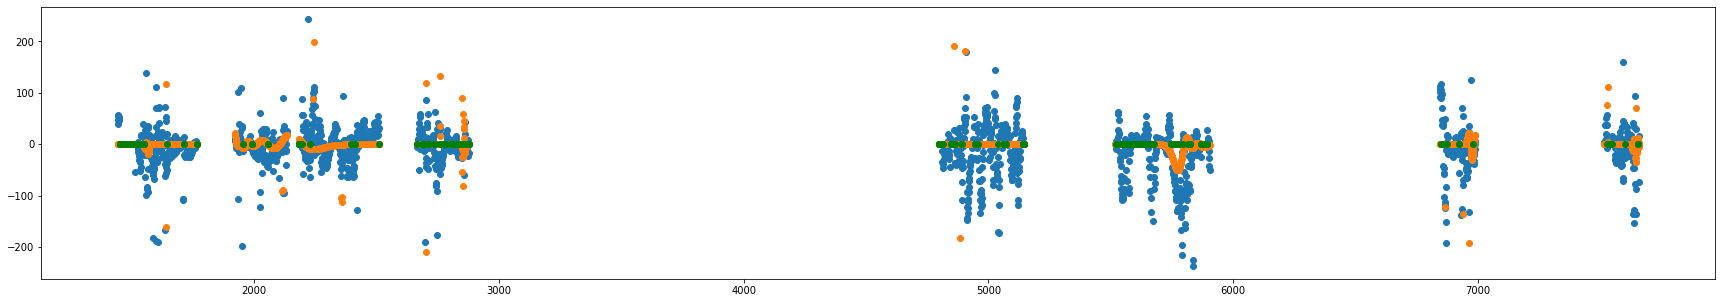

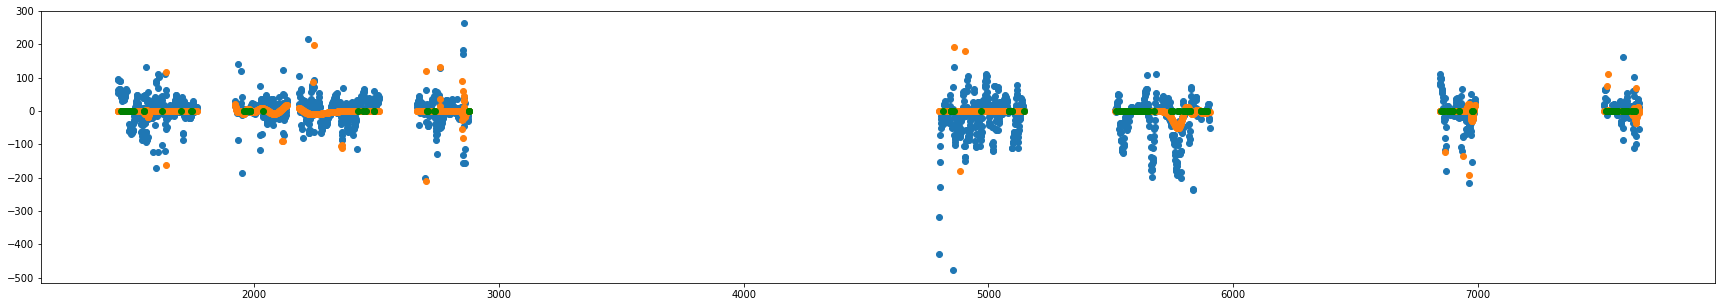

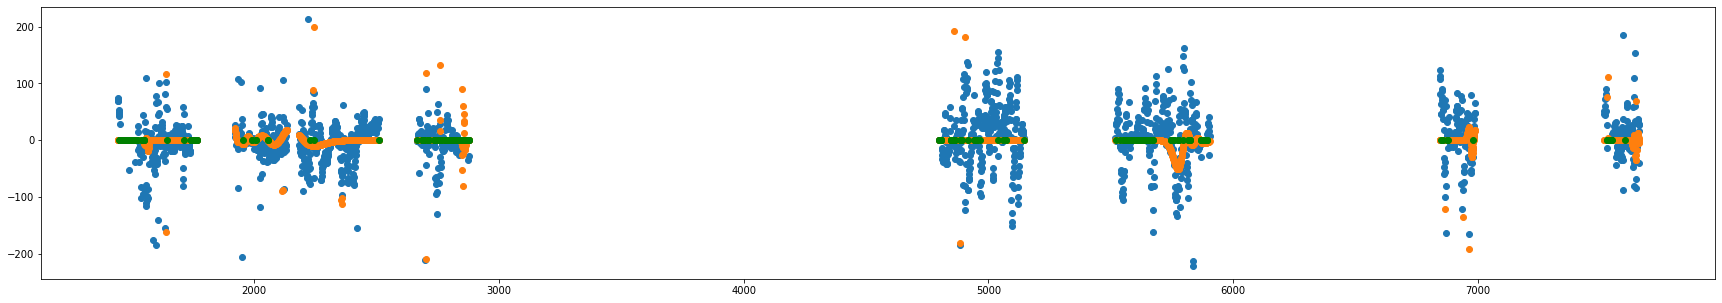

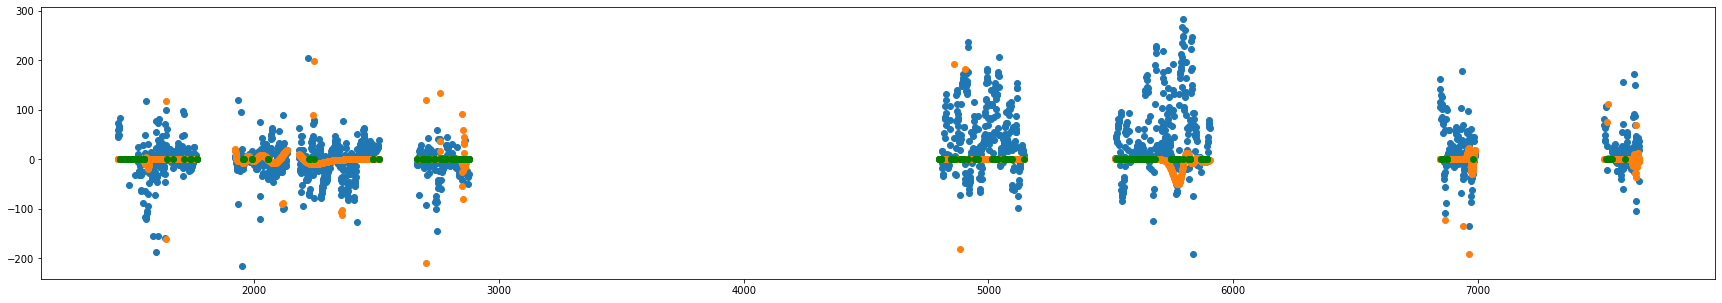

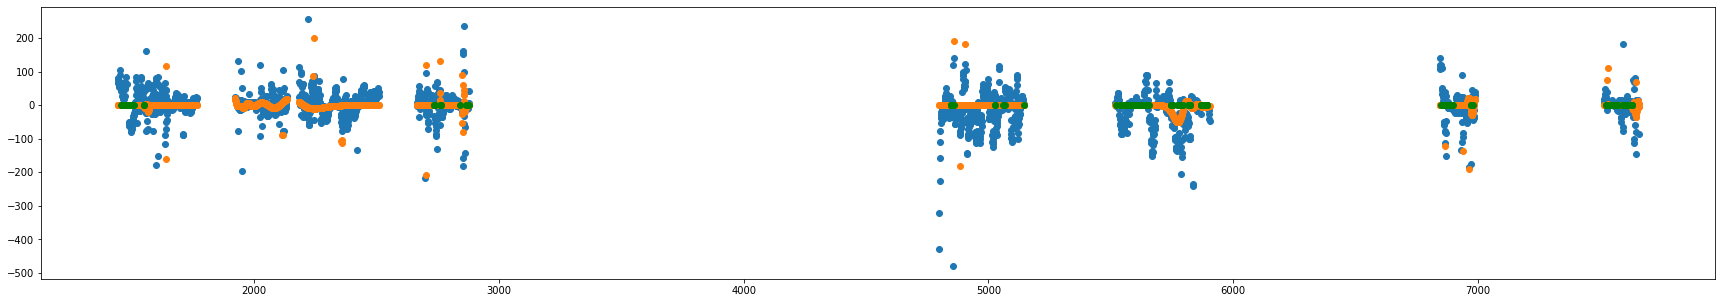

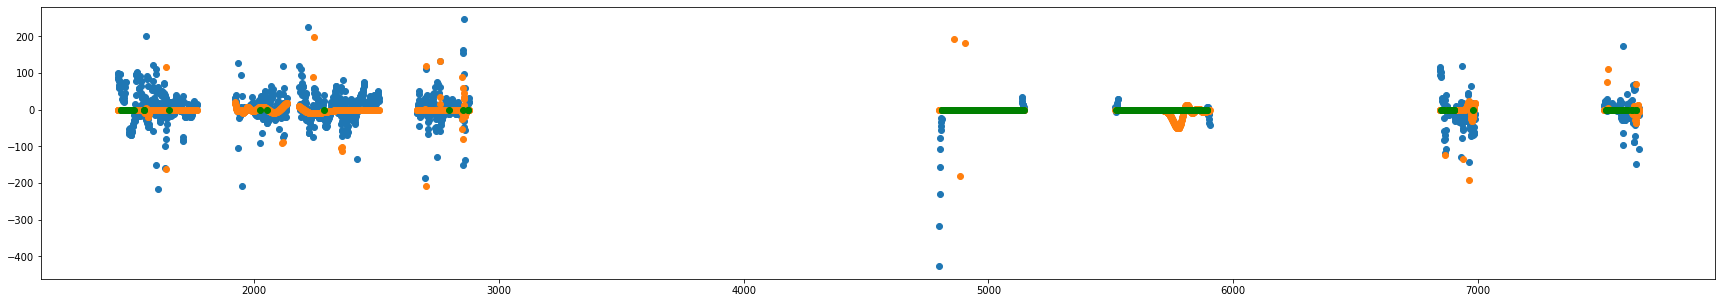

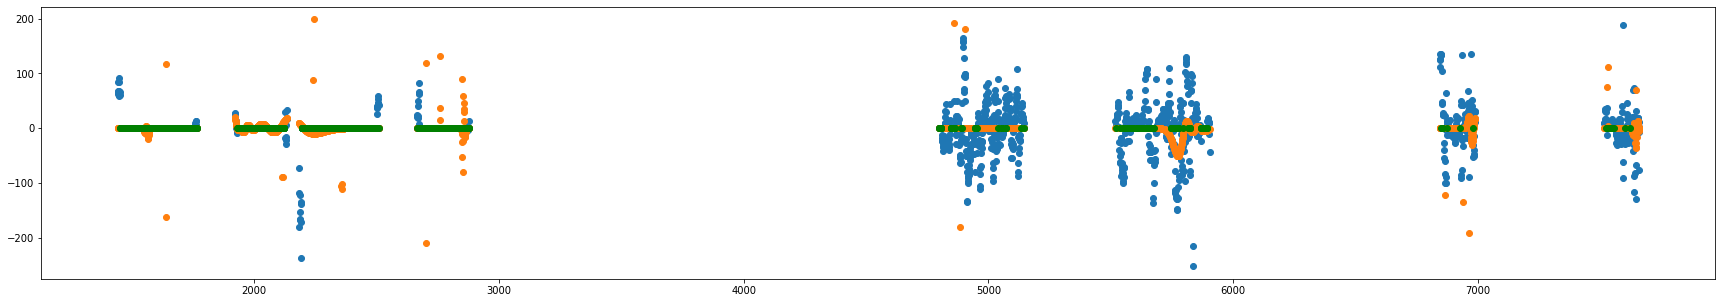

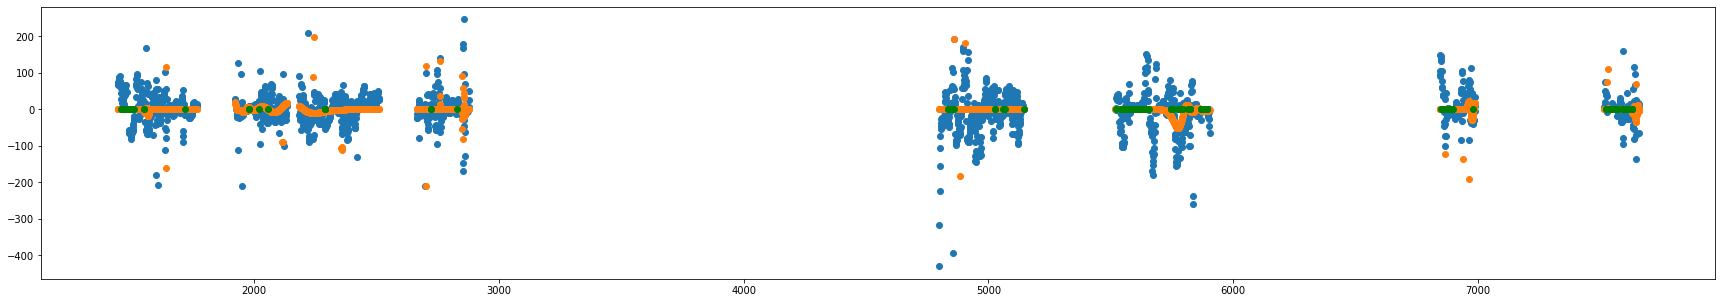

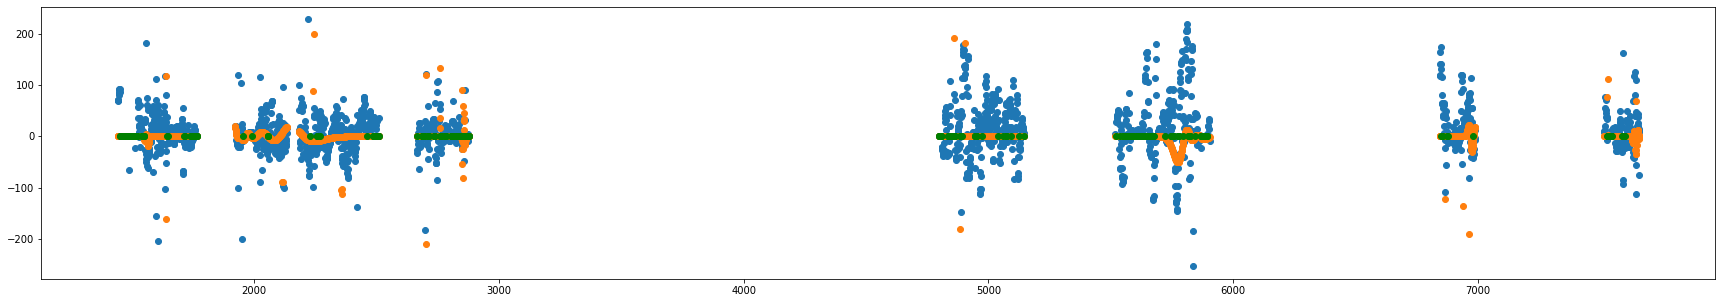

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 42.03795254840702
7th additional RBFlayer 999th epoch MSE Loss: 32.05595792501105
7th additional RBFlayer 1999th epoch MSE Loss: 31.94833479573105
7th additional RBFlayer 2999th epoch MSE Loss: 32.13926830882216
7th additional RBFlayer best loss : 31.87729114014077
change lr  0.1
----------------------------------------------


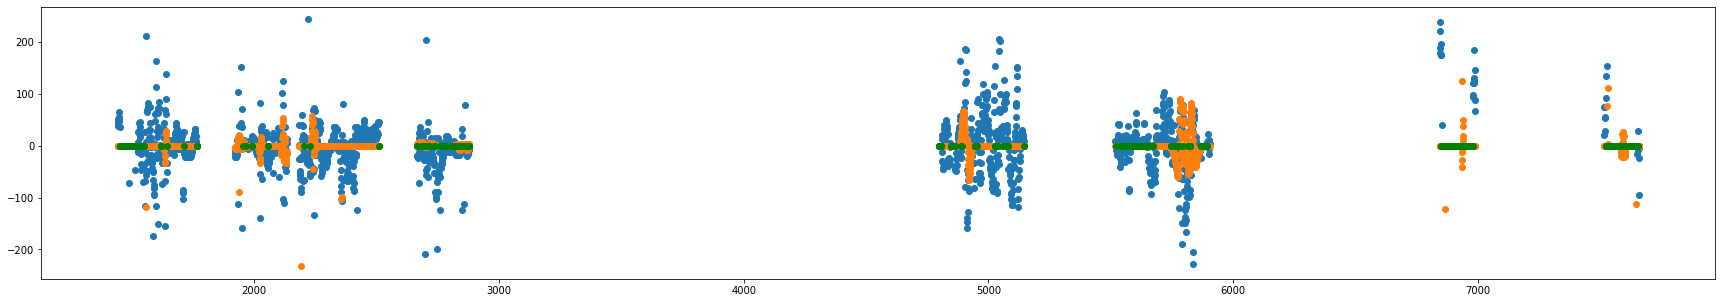

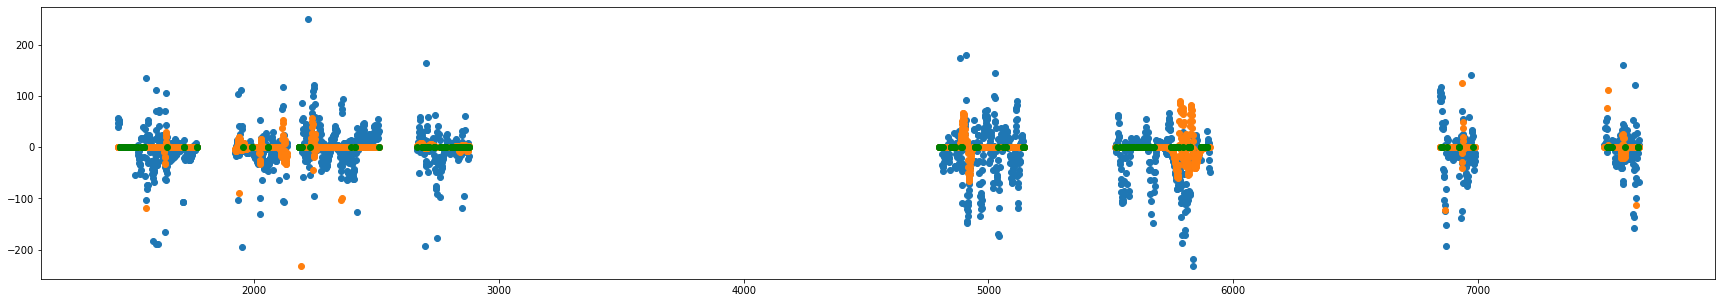

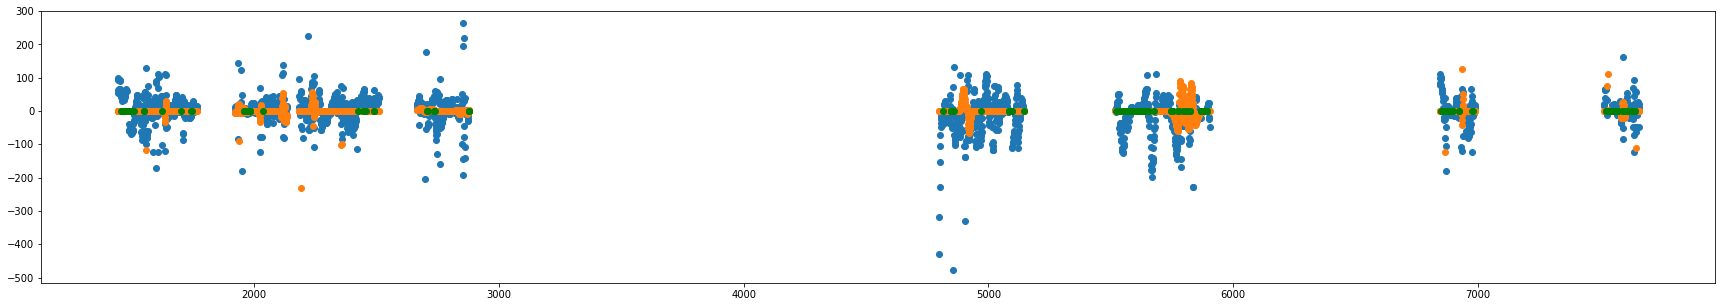

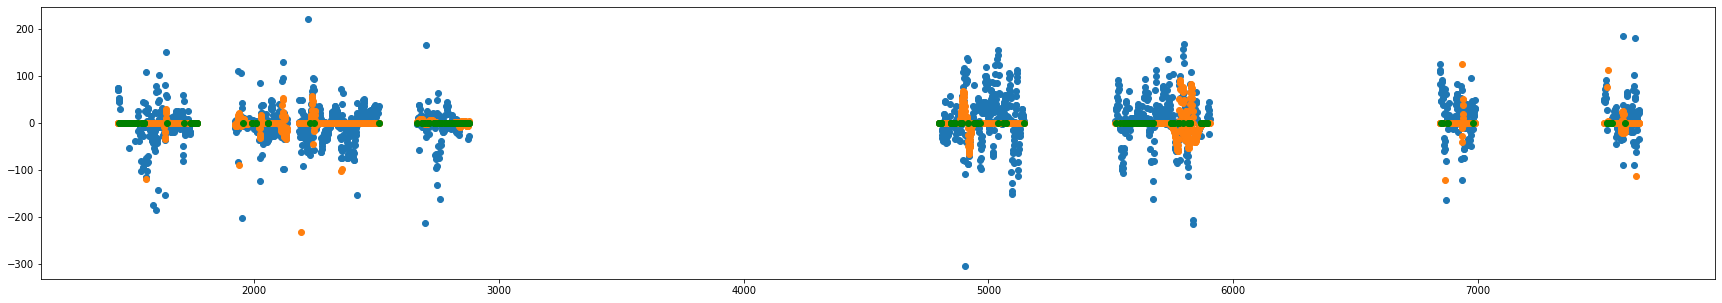

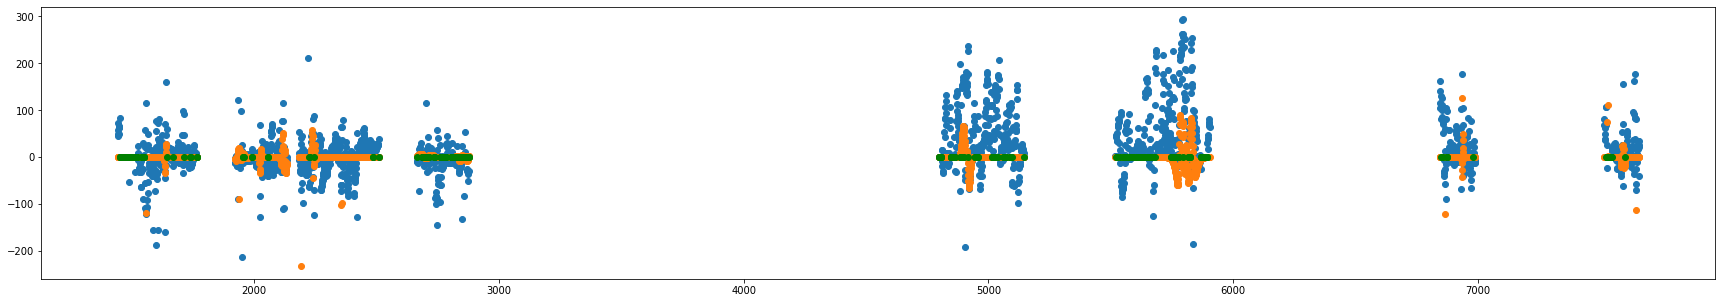

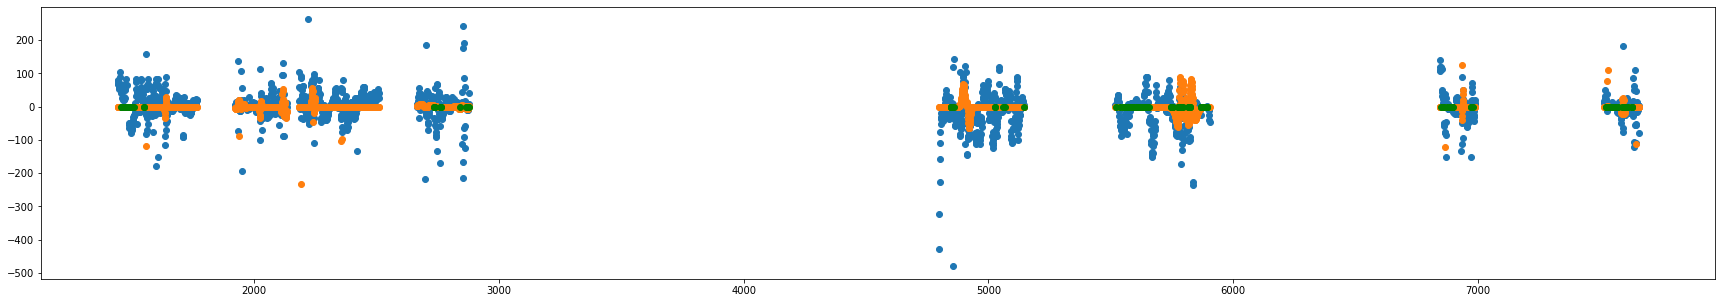

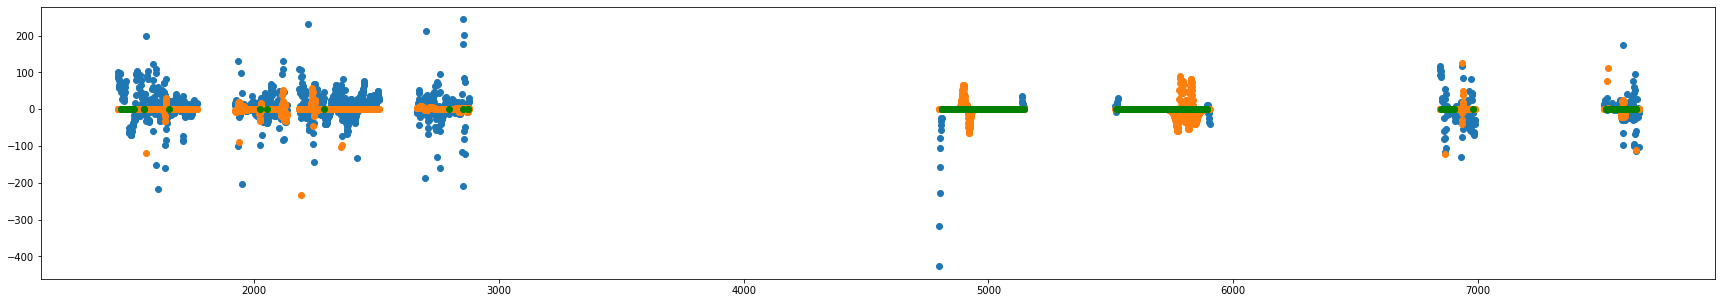

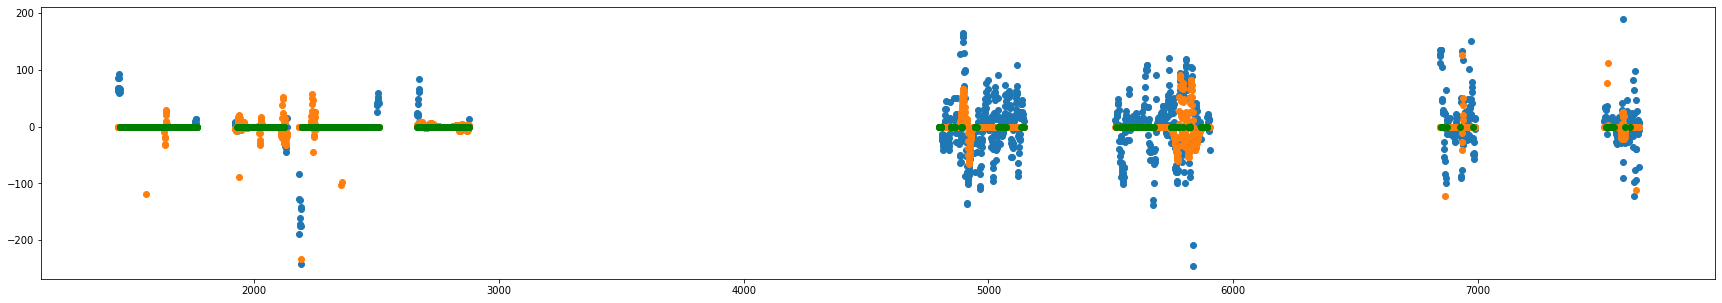

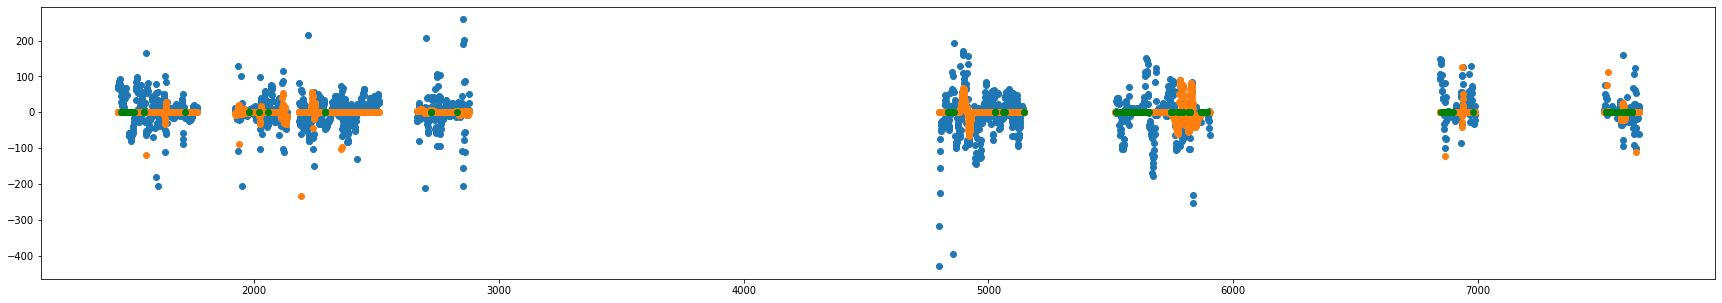

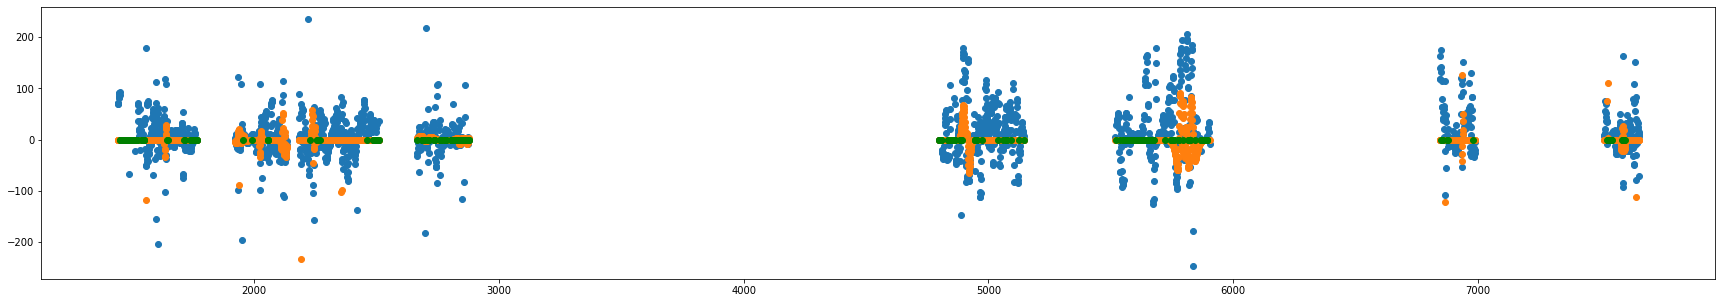

In [86]:
model = MSMRBFNN_ver2(10, 30, 10, device)
model.train(input, target, 3000, 1e-2, 32, 32, 0.)

In [87]:
unique_tensor = model.unique_tensor

In [95]:
unique_tensor

tensor([1442., 1443., 1444.,  ..., 7658., 7659., 7660.], device='cuda:0')

In [88]:
MR = torch.exp(-1 * (torch.pow((input - model.done_MC), 2) / \
                                (2 * torch.pow(model.done_MS, 2))))

pred = torch.mm(model.done_MW, MR)

In [89]:
pred.size()

torch.Size([1, 8759])

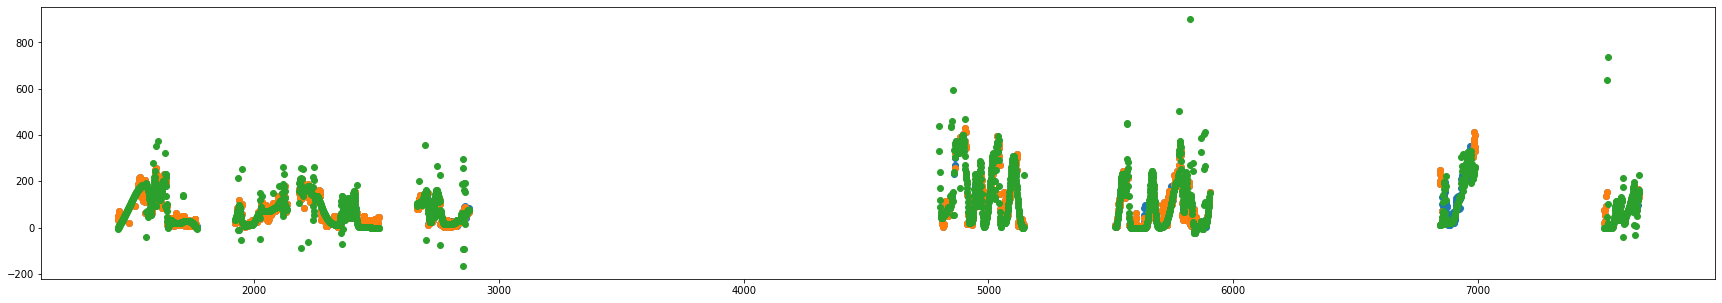

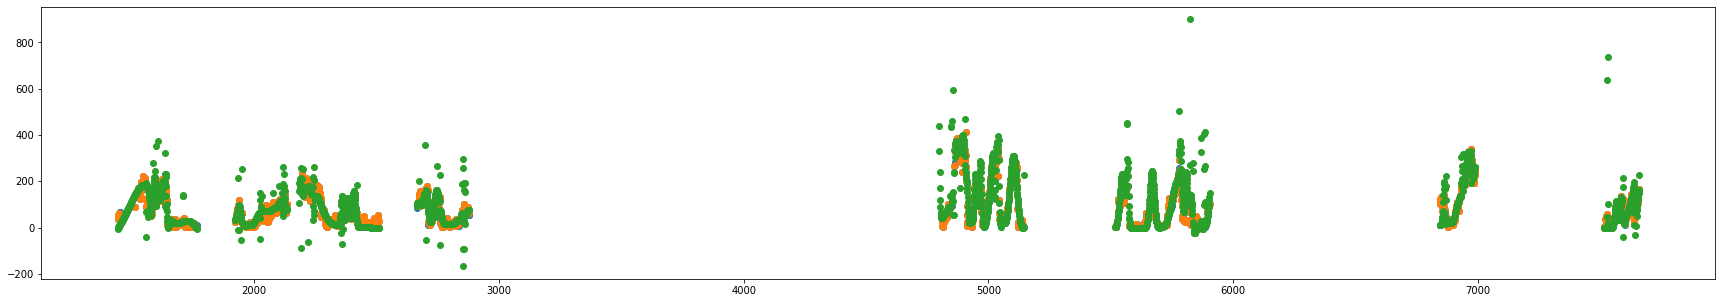

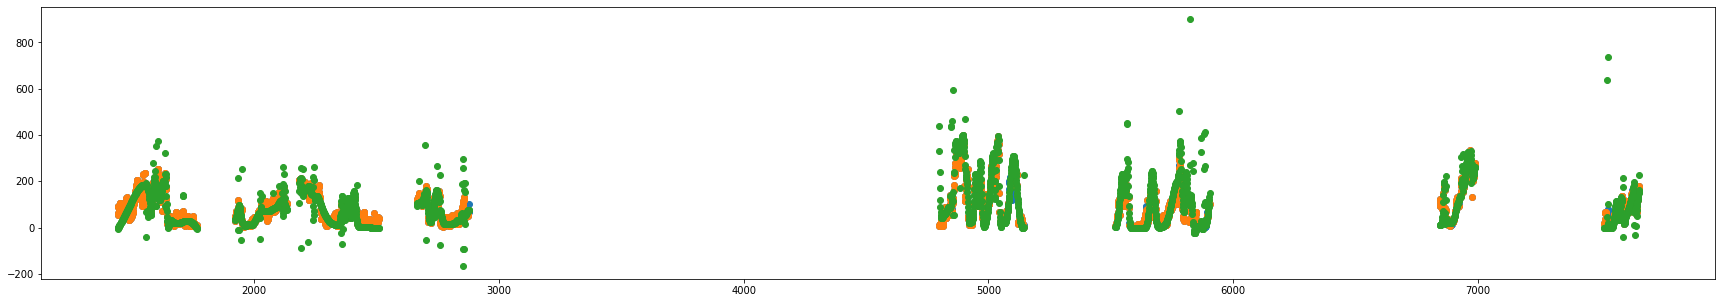

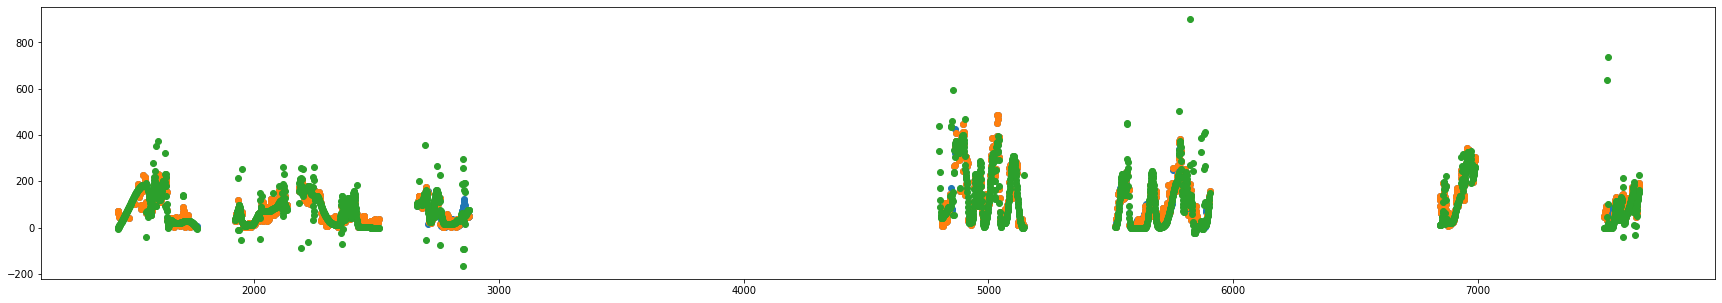

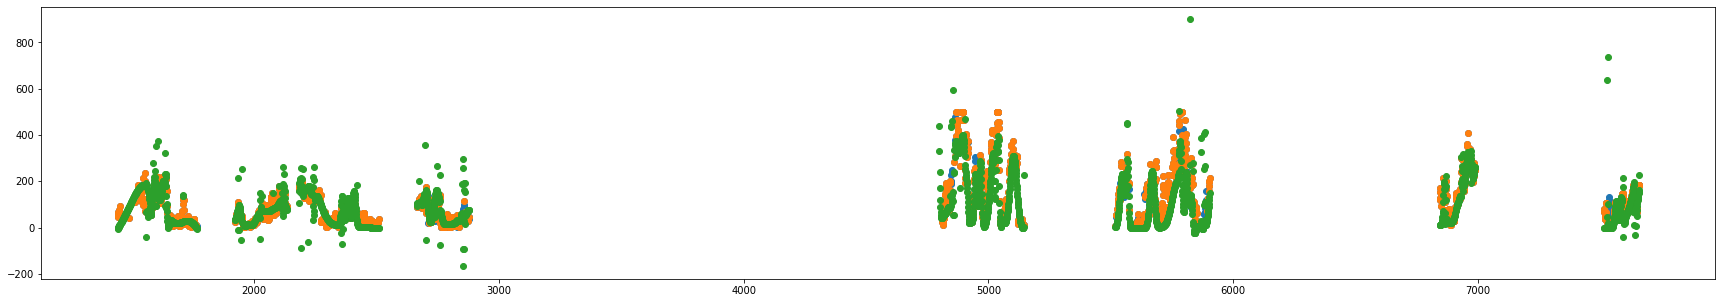

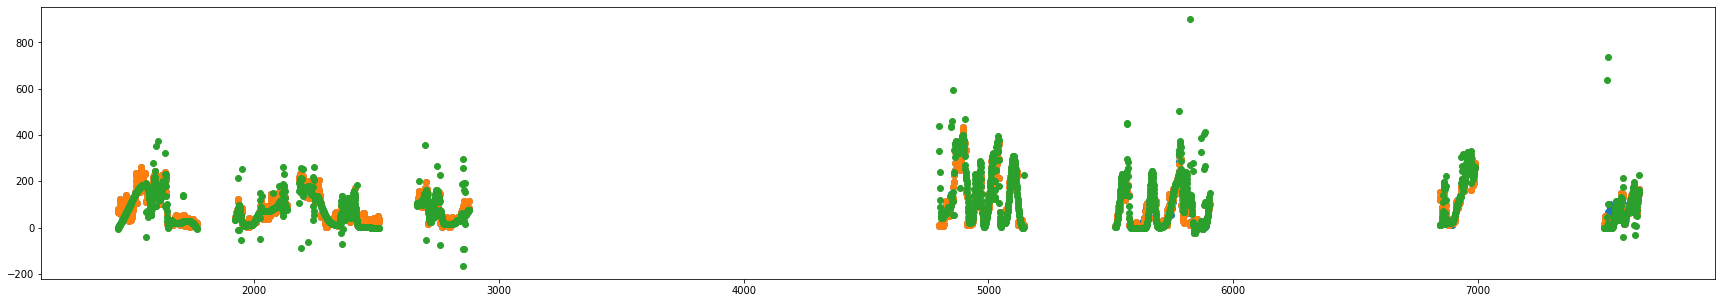

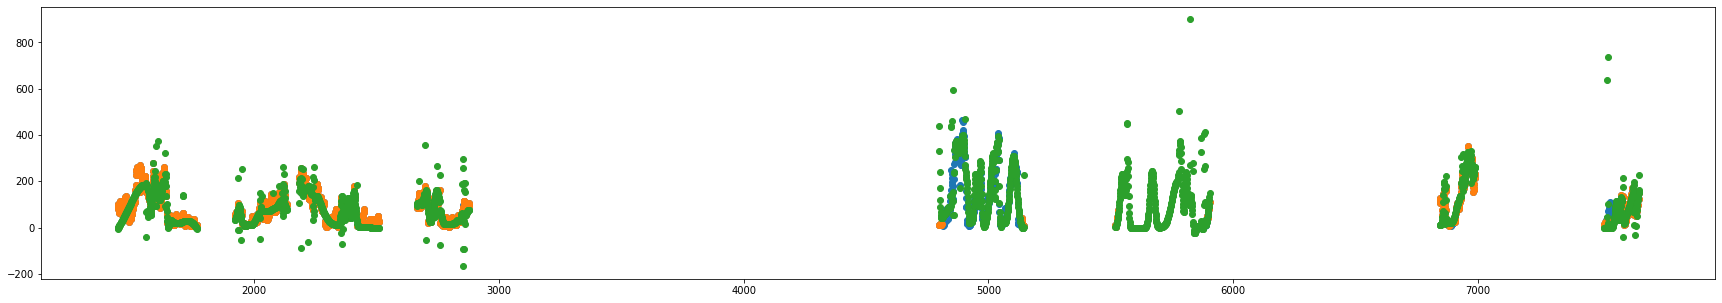

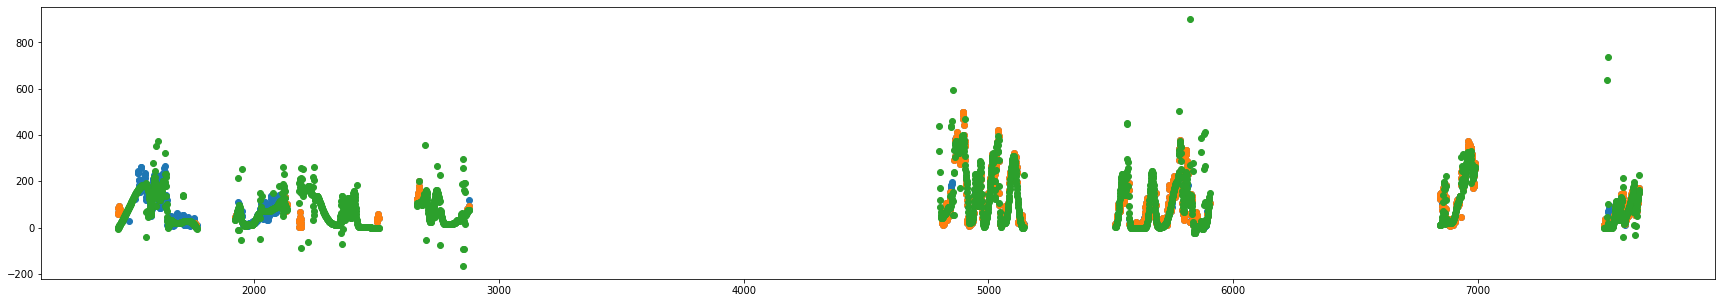

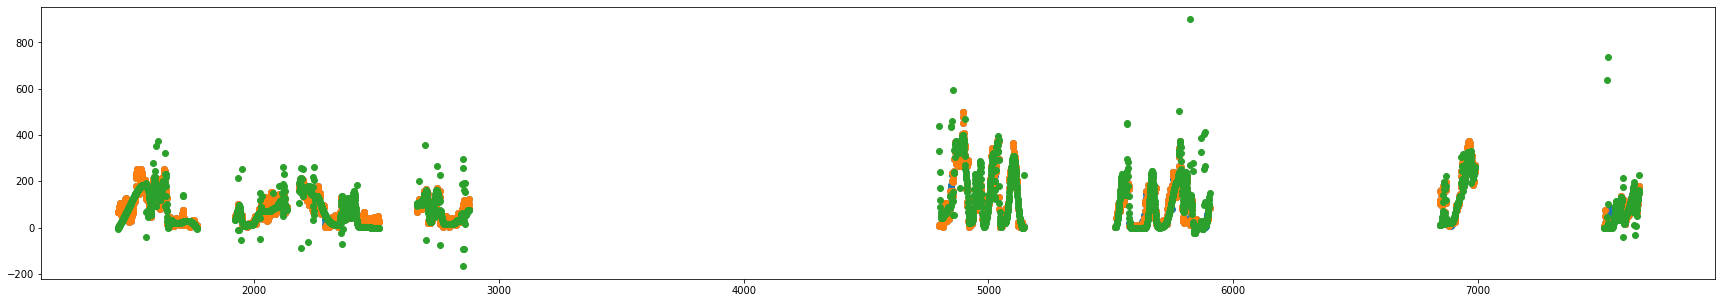

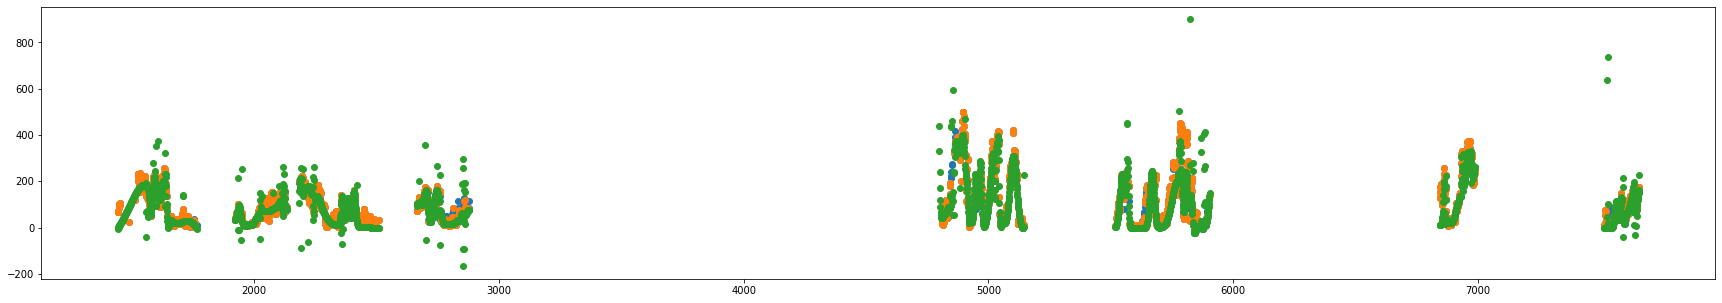

In [92]:
for i in range(10):
    plt.figure(figsize=(30,5))
    plt.scatter(unique_tensor.cpu().detach().numpy(), target_real[i][unique_tensor.to(int)].cpu().detach().numpy())
    plt.scatter(unique_tensor.cpu().detach().numpy(), target[i][unique_tensor.to(int)].cpu().detach().numpy())
    plt.scatter(unique_tensor.cpu().detach().numpy(), pred[0][unique_tensor.to(int)].cpu().detach().numpy())

In [33]:
missing_masking = torch.where(target.isnan(), 0.0, 1.0)

In [38]:
a = torch.sum(missing_masking, axis = 0)

In [45]:
index_ = torch.where(a == 0)[0]

In [41]:
torch.sum(a == 0)

tensor(426, device='cuda:0')

In [42]:
real = pd.read_csv("../dataset/pm25_ground.txt").drop(['datetime'], axis = 1)
real = real.reset_index(drop=True)
target_real = torch.tensor(real.values).T.to(device).reshape(36,len(real))
input = torch.tensor(real.index + 1, dtype=float).to(device)
real_masking = torch.where(target_real.isnan(), 0.0, 1.0)
b = torch.sum(real_masking, axis = 0)
torch.sum(b == 0)

tensor(188, device='cuda:0')

In [93]:
test_mask = real_masking - missing_masking

In [94]:
a = 0.0
for i in range(36):
    a += torch.sum(torch.abs(target_real[i][unique_tensor.to(int)][test_mask[:, unique_tensor.to(int)][i] != 0] - pred[0][unique_tensor.to(int)][test_mask[:, unique_tensor.to(int)][i] != 0]))

print(a / torch.sum(test_mask[:, unique_tensor.to(int)]))

tensor(66.6095, device='cuda:0', dtype=torch.float64)
